# XGB Model Training and SHAP computation using the Synthetic-events Dataset

**Author: Tesfagabir Meharizghi<br>Last Updated: 01/25/2021**

In this notebook, multiple experiments are run to:
- Take the hyperparameters that were generated during HPO tuning of experiment 1 and dataset 1
- Apply the same set of hyperparameters and train XGB models for other datasets
- And finally compare and analyze the feature importance results (SHAP & Builtin) model trainings

The main purpose of this notebook is to train XGB models with different synthetic datasets by using the same set of hyperparameters. This is mainly to see if we get similar results by training with different datasets with similar distribution.

*Note:* To run for each experiment, you need to change the experiment number (`EXP_NUMBER`) in every run.

Outputs:
- The following artifacts are saved:
    * Model artifacts
    * SHAP values and their corresponding scores for the specified number of val/test examples

Model Architecture Used:
- XGB

Dataset:
- Synthetic-events (Toy Dataset)

Requirements:
- Make sure that you have already generated multiple synthetic toy datasets (train/val/test splits) using [Create_toy_dataset_multiple.ipynb](../../data/toy_dataset/Create_toy_dataset_multiple.ipynb).

Observations:
- Even though, the list and order of the important features changes between the experiments, the most important features (SHAP & builtin) are the expected ones (_H and _U features). We are still getting the important features as _A, or _U in each experiment (SHAP & Builtin). However, we didn't get the complete list of the expected important features. These could be mainly because of the improper hyperparameter selection.

In [139]:
# pip install nb-black

In [140]:
#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [141]:
%load_ext lab_black

%load_ext autoreload

%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import sys

sys.path.append("../")

import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil
from collections import Counter, defaultdict, OrderedDict

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.image_uris import retrieve

import deep_id_pytorch

import xgboost_utils as xgb_utils
import shap_jacc_utils as sj_utils

## XGB Model Training

### Constants

In [143]:
# The original experiment number where the hyperparameters coming from
ORIGINAL_EXP_NUMBER = 1

# The current experiment number
EXP_NUMBER = 5

# Whether to preprocess data
PREPROCESS_DATA = False

# Whether to save SHAP scores
SAVE_SHAP_OUTPUT = True

# Whether to ouput SHAP explainer expected value
OUTPUT_SHAP_EXPLAINER = True

# Whether to shuffle val & test dataset for shap visualization purposes
SHUFFLE = True

# For seq_len=30
seq_len = 30

USE_FREQ = True  # Whether to use feature frequencies or one-hot for data preprocessing

nrows = 1e9

target_colname = "label"
uid_colname = "patient_id"
target_value = "1"

rev = False

model_name = "xgb"
dataset = "Synthetic-events"

# For model early stopping criteria
EARLY_STOPPING = "intersection_similarity"  # Values are any of these: ['intersection_similarity', 'loss']

# SHAP related constants
N_BACKGROUND = None  # Number of background examples
BACKGROUND_NEGATIVE_ONLY = False  # If negative examples are used as background
BACKGROUND_POSITIVE_ONLY = False  # If positive examples are used as background
TEST_POSITIVE_ONLY = False  # If only positive examples are selected
IS_TEST_RANDOM = (
    False  # If random test/val examples are selected for shap value computation
)
SORT_SHAP_VALUES = False  # Whether to sort per-patient shap values for visualization

SHAP_SCORE_ABSOLUTE = True  # Whether to consider the absolute value of a shap score #TODO: Check this before running.

train_data_path = f"../../../data/toy_dataset/data/{seq_len}/{EXP_NUMBER:02}/train.csv"
valid_data_path = f"../../../data/toy_dataset/data/{seq_len}/{EXP_NUMBER:02}/val.csv"
test_data_path = f"../../../data/toy_dataset/data/{seq_len}/{EXP_NUMBER:02}/test.csv"

model_save_path = (
    f"./output/{seq_len}/ExpIII/{EXP_NUMBER:02}/{model_name}/models/model_{'{}'}.pkl"
)
shap_save_path_pattern = f"./output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/shap/{'{}'}_shap_{'{}'}.pkl"  # SHAP values path for a given dataset split (train/val/test) (data format (features, scores, patient_ids))

# Dataset preprocessing
x_train_one_hot_path = (
    f"output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/train_one_hot.csv"
)
x_valid_one_hot_path = (
    f"output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/val_one_hot.csv"
)
x_test_one_hot_path = (
    f"output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/test_one_hot.csv"
)

x_train_data_path = (
    f"output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/train.csv"
)
x_valid_data_path = f"output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/val.csv"
x_test_data_path = f"output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/data/test.csv"

s3_output_data_dir = (
    f"s3://merck-paper-bucket/{dataset}/ExpIII/{seq_len}/{EXP_NUMBER:02}/data"
)

# Model training
BUCKET = "merck-paper-bucket"
DATA_PREFIX = f"{dataset}/ExpIII/{seq_len}/{EXP_NUMBER:02}/data"
MODEL_PREFIX = f"{dataset}/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}".format(
    seq_len
)
label = "label"

original_output_results_path = f"output/ExpIII/{seq_len}/{ORIGINAL_EXP_NUMBER:02}/{model_name}/hpo_results/results.csv"
output_results_path = (
    f"output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/hpo_results/results.csv"
)

local_model_dir = f"output/ExpIII/{seq_len}/{EXP_NUMBER:02}/{model_name}/models/"
s3_output_path = f"s3://{BUCKET}/{MODEL_PREFIX}/output"

###Algorithm config
ALGORITHM = "xgboost"
REPO_VERSION = "1.2-1"

###Hyperparameter tuning config
TRAIN_INSTANCE_TYPE = "ml.m5.4xlarge"  #'ml.m4.16xlarge'
TRAIN_INSTANCE_COUNT = 1
MAX_PARALLEL_JOBS = 4
MAX_TRAIN_JOBS = 10

EVALUATION_METRIC = "auc"
OBJECTIVE = "binary:logistic"
OBJECTIVE_METRIC_NAME = "validation:auc"

# # Update hyperparameter ranges
# HYPERPARAMETER_RANGES = {
#     "eta": ContinuousParameter(0, 1),
#     "alpha": ContinuousParameter(0, 2),
#     "max_depth": IntegerParameter(1, 3),
# }

HYPERPARAMETER_RANGES = {
    "eta": ContinuousParameter(0.1, 0.3),  # (0.1, 0.5)
    "alpha": ContinuousParameter(0, 1),  # (0, 2)
    "max_depth": IntegerParameter(1, 2),  # (1, 10)
    "gamma": ContinuousParameter(0, 2),  # (0, 5),
    "num_round": IntegerParameter(20, 50),  # (200, 500), #(20, 50)
    "colsample_bylevel": ContinuousParameter(0.1, 0.2),  # (0.1, 1.0), #
    "colsample_bynode": ContinuousParameter(0.1, 0.3),  # (0.1, 1.0), #
    "colsample_bytree": ContinuousParameter(0.5, 0.7),  # (0.5, 1.0), #(0.5, 0.7)
    "lambda": ContinuousParameter(0, 50),  # (0, 1000), #
    "max_delta_step": IntegerParameter(0, 3),  # (0, 10),
    "min_child_weight": ContinuousParameter(0, 5),  # (0, 120), #(0, 10)
    "subsample": ContinuousParameter(0.5, 0.7),  # (0.5, 1.0), #(0.5, 0.7)
}

# HYPERPARAMETER_RANGES = {
#     "eta": ContinuousParameter(0.1, 0.5),
#     "alpha": ContinuousParameter(0, 2),
#     "max_depth": IntegerParameter(1, 10),
#     "gamma": ContinuousParameter(0, 5),
#     "num_round": IntegerParameter(200, 500),
#     "colsample_bylevel": ContinuousParameter(0.1, 1.0),
#     "colsample_bynode": ContinuousParameter(0.1, 1.0),
#     "colsample_bytree": ContinuousParameter(0.5, 1.0),
#     "lambda": ContinuousParameter(0, 1000),
#     "max_delta_step": IntegerParameter(0, 10),
#     "min_child_weight": ContinuousParameter(0, 120),
#     "subsample": ContinuousParameter(0.5, 1.0),
# }

In [144]:
# Model Output Directory
model_save_dir = os.path.dirname(model_save_path)
shap_save_dir = os.path.dirname(shap_save_path_pattern)

if os.path.exists(model_save_dir):
    # Remove model save directory if exists
    shutil.rmtree(model_save_dir)
if os.path.exists(shap_save_dir):
    # Remove model save directory if exists
    shutil.rmtree(shap_save_dir)
os.makedirs(model_save_dir)
os.makedirs(shap_save_dir)
print(f"New directory created: {model_save_dir}")
print(f"New directory created: {shap_save_dir}")

New directory created: ./output/30/ExpIII/05/xgb/models
New directory created: ./output/ExpIII/30/05/xgb/shap


## 2. XGBoost Model Training

### Data Preprocessing

In [145]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2710,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,backache_N,tachycardia_H,hay_fever_N,dental_exam_N,foot_pain_N,ingrown_nail_N,eye_exam_N,quad_injury_N,0,40S1HVN02C
1,2265,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ACL_tear_N,myopia_N,cut_finger_N,cold_sore_N,normal_bmi_U,pneumonia_H,annual_physical_N,peanut_allergy_N,0,0VRRSQZL1D
2,1514,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,cold_sore_N,dental_exam_N,backache_N,myopia_N,annual_physical_N,resistent_hyp_H,hay_fever_N,quad_injury_N,0,8ZZITWVQ9E
3,737,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,cut_finger_N,headache_N,backache_N,...,apnea_H,dental_exam_N,annual_physical_N,dental_exam_N,eye_exam_N,eye_exam_N,AMI_A,cold_sore_N,0,LC11NXUQ5N
4,653,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,myopia_N,cold_sore_N,foot_pain_N,eye_exam_N,foot_pain_N,dental_exam_N,backache_N,quad_injury_N,0,IFJE3SHQS6


In [146]:
tokens = xgb_utils.get_valid_tokens(df, seq_len)

In [147]:
if PREPROCESS_DATA:
    xgb_utils.prepare_data(
        train_data_path,
        x_train_one_hot_path,
        x_train_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        valid_data_path,
        x_valid_one_hot_path,
        x_valid_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
    xgb_utils.prepare_data(
        test_data_path,
        x_test_one_hot_path,
        x_test_data_path,
        seq_len,
        target_colname,
        tokens,
        s3_output_data_dir,
        use_freq=USE_FREQ,
    )
else:
    local_dir = os.path.dirname(x_train_data_path)
    xgb_utils.copy_data_to_s3(local_dir, s3_output_data_dir)

Copying train data to S3...
Copying val data to S3...
Copying test data to S3...
Success!


### XGBoost Model Training

In [148]:
# Read HPO params
df_hpo0 = pd.read_csv(original_output_results_path)
print(df_hpo0.shape)
df_hpo0.head(2)

(10, 27)


,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,TrainingElapsedTimeSeconds,model,dataset,seq_len,s3_path,local_path,val_AUC,test_AUC,val_Intersection_Sim,test_Intersection_Sim
0,0.084537,0.170514,0.284080,0.580087,0.230492,0.00000,6.960190,0.0,2.0,3.490784,...,70.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/01...,output/30/01/xgb/models/sagemaker-xgboost-2101...,0.905427,0.897858,0.383683,0.384167
1,0.088697,0.159328,0.283506,0.587418,0.279165,0.42694,37.718505,0.0,2.0,3.375425,...,52.0,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/30/01...,output/30/01/xgb/models/sagemaker-xgboost-2101...,0.903856,0.898104,0.239417,0.240583


In [149]:
# Get only the parameters and other metadata and copy to a separate DataFrame
columns = df_hpo0.columns.tolist()
# Select the hyperparameters and other necessary cols (seq-len, model_name, etc.)
selected_columns = columns[:12] + columns[18:21]
df_hpo = df_hpo0[selected_columns]
print(df_hpo.shape)
df_hpo.head(2)

(10, 15)


,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,num_round,subsample,model,dataset,seq_len
0,0.084537,0.170514,0.284080,0.580087,0.230492,0.00000,6.960190,0.0,2.0,3.490784,44.0,0.688921,xgb,Synthetic-events,30
1,0.088697,0.159328,0.283506,0.587418,0.279165,0.42694,37.718505,0.0,2.0,3.375425,22.0,0.682185,xgb,Synthetic-events,30


In [150]:
### SageMaker Initialization
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
smclient = boto3.Session().client("sagemaker")

sess = sagemaker.Session()

container = retrieve(ALGORITHM, region, version=REPO_VERSION)

start = time.time()
print("Training for seq_len={}, label={}...".format(seq_len, label))
# Prepare the input train & validation data path
s3_input_train = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/train".format(BUCKET, DATA_PREFIX), content_type="csv"
)
s3_input_validation = sagemaker.inputs.TrainingInput(
    s3_data="s3://{}/{}/val".format(BUCKET, DATA_PREFIX), content_type="csv"
)

# Class Imbalance
scale_pos_weight = 1.0  # negative/positive

data_channels = {"train": s3_input_train, "validation": s3_input_validation}

model_paths = df_hpo.apply(
    xgb_utils.train_model,
    axis=1,
    args=(
        container,
        role,
        TRAIN_INSTANCE_COUNT,
        TRAIN_INSTANCE_TYPE,
        s3_output_path,
        sess,
        EVALUATION_METRIC,
        OBJECTIVE,
        scale_pos_weight,
        data_channels,
    ),
)

Training for seq_len=30, label=label...
2021-01-23 19:29:06 Starting - Starting the training job...
2021-01-23 19:29:32 Starting - Launching requested ML instancesProfilerReport-1611430146: InProgress
.........
2021-01-23 19:30:53 Starting - Preparing the instances for training...
2021-01-23 19:31:33 Downloading - Downloading input data...
2021-01-23 19:32:04 Training - Training image download completed. Training in progress.
2021-01-23 19:32:04 Uploading - Uploading generated training model.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined d

In [151]:
# Add s3_models_paths to the dataframe
df_hpo["s3_path"] = model_paths

In [152]:
def get_and_copy_training_job(row, s3_output_dir, local_output_dir):
    """Get a training job from s3 and copy to local dir."""
    s3_model_path = row["s3_path"]
    job_name = s3_model_path.split("/")[-3]

    if not os.path.exists(local_output_dir):
        os.makedirs(local_output_dir)

    output_fname = f"{job_name}.tar.gz"
    local_model_path = os.path.join(local_output_dir, output_fname)

    command = f"aws s3 cp --quiet {s3_model_path} {local_model_path}"

    os.system(command)
    return s3_model_path, local_model_path


def save_hpo_results(df, output_path):
    """Save HPO training jobs metadata."""
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    df.to_csv(output_path, index=False)

In [153]:
print("Copying model artifacts from s3 to local...")
model_paths = df_hpo.apply(
    get_and_copy_training_job, args=(s3_output_path, local_model_dir), axis=1
)
print(f"Saving hpo train results to {output_results_path}...")

local_paths = [path[1] for path in model_paths]
df_hpo["local_path"] = local_paths

save_hpo_results(df_hpo, output_results_path)
print("SUCCESS!")

Copying model artifacts from s3 to local...
Saving hpo train results to output/ExpIII/30/05/xgb/hpo_results/results.csv...
SUCCESS!


## Model Validation and Visualization

In [154]:
df_hpo = pd.read_csv(output_results_path)
print(df_hpo.shape)
df_hpo.head()

(10, 17)


,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,num_round,subsample,model,dataset,seq_len,s3_path,local_path
0,0.084537,0.170514,0.284080,0.580087,0.230492,0.000000,6.960190,0.0,2.0,3.490784,44.0,0.688921,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...
1,0.088697,0.159328,0.283506,0.587418,0.279165,0.426940,37.718505,0.0,2.0,3.375425,22.0,0.682185,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...
2,0.835199,0.108679,0.180286,0.564033,0.298695,1.434551,17.296006,3.0,2.0,1.382886,36.0,0.640791,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...
3,0.060123,0.169096,0.214744,0.692486,0.218188,0.736939,14.333237,1.0,1.0,4.286682,50.0,0.551523,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...
4,0.234247,0.183984,0.157849,0.595210,0.290516,0.237530,29.179551,2.0,1.0,1.853467,48.0,0.638667,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...


In [155]:
df_train = pd.read_csv(x_train_one_hot_path)
df_val = pd.read_csv(x_valid_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)
print(df_train.shape, df_val.shape, df_test.shape)

# Shuffle val & test for better visualization #TODO: Check this
if SHUFFLE:
    df_val = df_val.sample(frac=1)
    df_test = df_test.sample(frac=1)

(18000, 32) (6000, 32) (6000, 32)


In [156]:
# load JS visualization code to notebook
shap.initjs()

In [157]:
# For each model.
def compute_shap(
    row,
    shap_path_pattern,
    df_train,
    df_val,
    df_test,
    absolute=True,
    test_positive_only=True,
    save_output=False,
    visualize=False,
):
    model_path = row["local_path"]
    job_name = model_path.split(".")[-3]
    # job_name = row["TrainingJobName"]
    print(f"Processing for training job name = {job_name}...")
    val_shap_path = shap_save_path_pattern.format("val", job_name)
    test_shap_path = shap_save_path_pattern.format("test", job_name)
    # Load the copied model
    xgb_model = xgb_utils.load_model(model_path, remove=False)

    # Compute the val & test auc of the model
    X_train = df_train.iloc[:, 1:-1]
    X_val = df_val.iloc[:, 1:-1]
    X_test = df_test.iloc[:, 1:-1]

    train_auc = xgb_model.eval(
        xgb.DMatrix(X_train.values, df_train[target_colname].values)
    )
    train_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_train.values, df_train[target_colname].values)
    )

    val_auc = xgb_model.eval(xgb.DMatrix(X_val.values, df_val[target_colname].values))
    val_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_val.values, df_val[target_colname].values)
    )

    test_auc = xgb_model.eval(
        xgb.DMatrix(X_test.values, df_test[target_colname].values)
    )
    test_prob_scores = xgb_model.predict(
        xgb.DMatrix(X_test.values, df_test[target_colname].values)
    )

    train_auc = float(train_auc.rsplit(":", 1)[-1])
    val_auc = float(val_auc.rsplit(":", 1)[-1])
    test_auc = float(test_auc.rsplit(":", 1)[-1])
    print(f"Train AUC= {train_auc:.4f}, Val AUC={val_auc:.4f}, Test AUC={test_auc:.4f}")

    print("Computing SHAP values...")
    if save_output:
        result = sj_utils.get_xgboost_features_and_shap_scores(
            xgb_model,
            df_train,
            df_val,
            val_shap_path,
            save_output=save_output,
            n_test=None,
            n_background=None,
            background_negative_only=BACKGROUND_NEGATIVE_ONLY,
            background_positive_only=BACKGROUND_POSITIVE_ONLY,
            test_positive_only=TEST_POSITIVE_ONLY,
            is_test_random=IS_TEST_RANDOM,
            output_explainer=OUTPUT_SHAP_EXPLAINER,
        )

        val_features, val_scores, val_patients = (
            result[0][0],
            result[0][1],
            result[0][2],
        )

        # Get the SHAP Explainer expected value if needed
        shap_expected_value = None
        if OUTPUT_SHAP_EXPLAINER:
            shap_expected_value = result[1]

        (
            test_features,
            test_scores,
            test_patients,
        ) = sj_utils.get_xgboost_features_and_shap_scores(
            xgb_model,
            df_train,
            df_test,
            test_shap_path,
            save_output=save_output,
            n_test=None,
            n_background=None,
            background_negative_only=BACKGROUND_NEGATIVE_ONLY,
            background_positive_only=BACKGROUND_POSITIVE_ONLY,
            test_positive_only=TEST_POSITIVE_ONLY,
            is_test_random=IS_TEST_RANDOM,
            output_explainer=False,
        )
    else:
        (val_features, val_scores, val_patients) = sj_utils.load_pickle(val_shap_path)
        (test_features, test_scores, test_patients) = sj_utils.load_pickle(
            test_shap_path
        )

    # Get positive rows and data if needed
    if test_positive_only:
        val_positive_rows = df_val.iloc[:, -1] == 1  # Only positive labels
        test_positive_rows = df_test.iloc[:, -1] == 1  # Only positive labels
        X_val = X_val[val_positive_rows]
        X_test = X_test[test_positive_rows]
        val_prob_scores = val_prob_scores[val_positive_rows].flatten().tolist()
        test_prob_scores = test_prob_scores[test_positive_rows].flatten().tolist()

    print("Computing Intersection Similarity...")
    #     import pdb

    #     pdb.set_trace()
    val_avg_sim, val_sim = sj_utils.get_model_intersection_similarity(
        (val_features, val_scores), absolute=absolute, df_one_hot=X_val
    )
    test_avg_sim, test_sim = sj_utils.get_model_intersection_similarity(
        (test_features, test_scores), absolute=absolute, df_one_hot=X_test
    )
    print(f"Val Int. Simi={val_avg_sim:.4f}, Test Int. Simi={test_avg_sim:.4f}")
    print("*" * 100)

    if visualize:
        print("Ploting Histograms of Train/Val/Test Predicted Scores...")
        _, axes = plt.subplots(1, 3, sharex=False, figsize=(15, 5))
        # Train
        scores = train_prob_scores.flatten().tolist()
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Train Scores (AUC={train_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="Frequencies",
            axes=axes,
            axes_idx=0,
        )
        # Val
        scores = val_prob_scores[:]
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Val Scores (AUC={val_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="",
            axes=axes,
            axes_idx=1,
        )
        # Test
        scores = test_prob_scores[:]
        axes = sj_utils.plot_histogram(
            scores,
            title=f"Test Scores (AUC={test_auc:.4f})",
            xlabel="Prediction Scores",
            ylabel="",
            axes=axes,
            axes_idx=2,
        )
        plt.show()

        print("Visualizing SHAP values of VAL examples...")
        n_val = len(val_prob_scores)
        n_vis_examples = 0
        for idx in range(n_val):
            prob_scores1 = val_prob_scores[idx]  # Model prediction
            if n_vis_examples > 2:
                break
            features1 = val_features[idx]
            scores1 = val_scores[idx]
            patient_id = val_patients[idx]
            patient_id = f"{patient_id}, Probability={prob_scores1:.4f}"

            if prob_scores1 >= 0.8:
                df_shap = pd.DataFrame(
                    np.array([features1, scores1]).T, columns=["events", "shap_vals"]
                )
                df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

                sj_utils.plot_shap_values(
                    df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
                )
                print(X_val.iloc[idx, :].tolist())
                if OUTPUT_SHAP_EXPLAINER:
                    shap.force_plot(
                        shap_expected_value,
                        np.array(scores1),
                        X_val.iloc[idx, :],
                        matplotlib=True,
                    )
                n_vis_examples += 1

        sj_utils.plot_histogram(
            val_sim,
            title=f"Average VAL Intersection Simi={val_avg_sim:.4f}",
            xlabel="Intersection Similarity",
            ylabel="Frequencies",
            axes=None,
        )

        print("Visualizing SHAP values of TEST examples...")
        num_test = len(test_prob_scores)
        n_vis_examples = 0
        for idx in range(num_test):
            prob_scores1 = test_prob_scores[idx]
            if n_vis_examples > 2:
                break
            features1 = test_features[idx]
            scores1 = test_scores[idx]
            patient_id = test_patients[idx]
            patient_id = f"{patient_id}, Probability={prob_scores1:.4f}"

            if prob_scores1 >= 0.8:
                df_shap = pd.DataFrame(
                    np.array([features1, scores1]).T, columns=["events", "shap_vals"]
                )
                df_shap["shap_vals"] = pd.to_numeric(df_shap["shap_vals"])

                sj_utils.plot_shap_values(
                    df_shap, patient_id, sort=SORT_SHAP_VALUES, figsize=(10, 5)
                )
                print(X_test.iloc[idx, :].tolist())
                if OUTPUT_SHAP_EXPLAINER:
                    shap.force_plot(
                        shap_expected_value,
                        np.array(scores1),
                        X_test.iloc[idx, :],
                        matplotlib=True,
                    )

                n_vis_examples += 1

        sj_utils.plot_histogram(
            test_sim,
            title=f"Average TEST Intersection Simi={test_avg_sim:.4f}",
            xlabel="Intersection Similarity",
            ylabel="Frequencies",
            axes=None,
        )
        print(
            "Finally computing and visualizing the global feature importance of the best model...."
        )

        # summarize the effects of all the features
        shap.summary_plot(
            np.array(test_scores),
            test_features[0],
            max_display=20,
        )

        feat_importance = sj_utils.get_global_feature_importance(
            test_features, test_scores, absolute=absolute
        )
        sj_utils.plot_global_feature_importance(feat_importance)
        print("All tasks SUCCESSFULLY completed!")

    result = (val_auc, test_auc, val_avg_sim, test_avg_sim)
    return result

Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-29-06-133...
Train AUC= 0.8950, Val AUC=0.8949, Test AUC=0.8996
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-29-06-133.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-29-06-133.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.4219, Test Int. Simi=0.4235
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


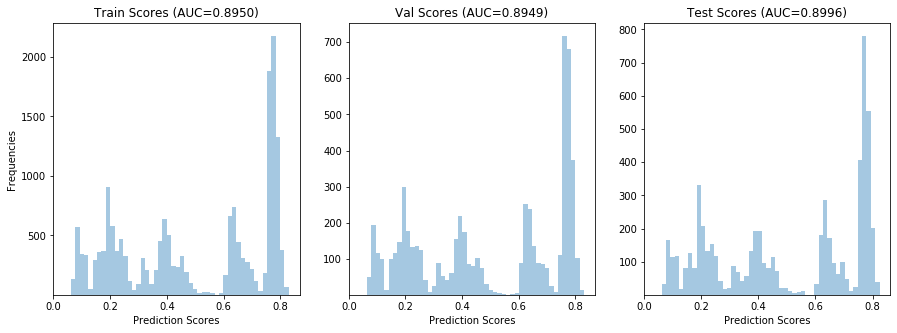

Visualizing SHAP values of VAL examples...


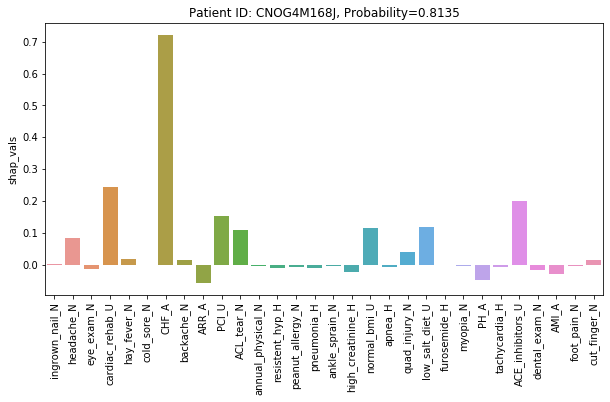

[0, 4, 1, 0, 3, 0, 1, 2, 0, 0, 4, 4, 0, 1, 0, 0, 0, 0, 0, 4, 0, 0, 2, 0, 0, 0, 0, 0, 2, 1]


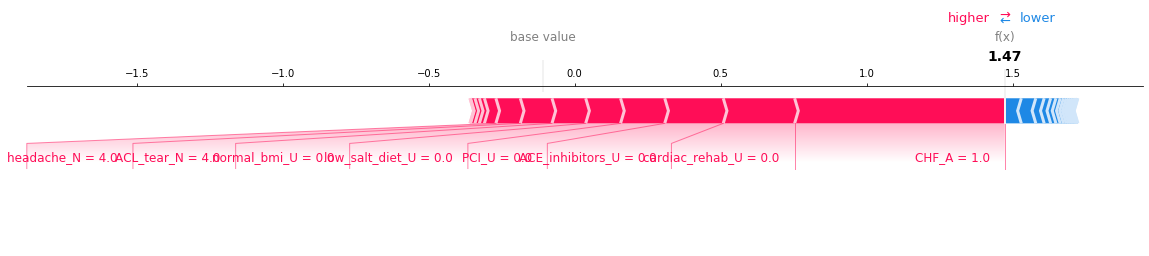

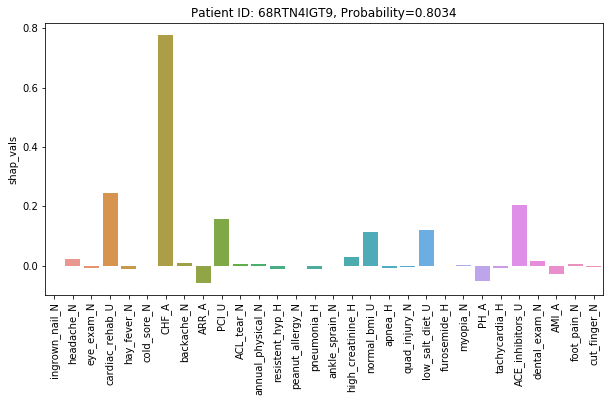

[1, 3, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2]


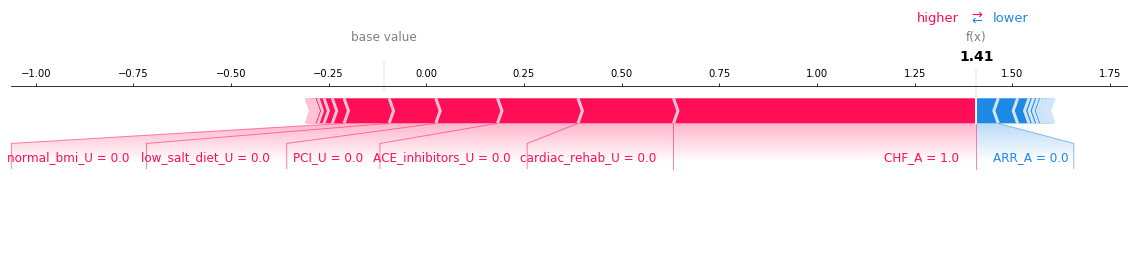

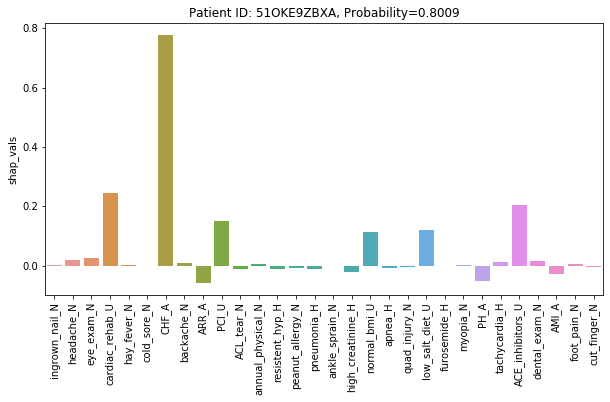

[0, 2, 2, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2]


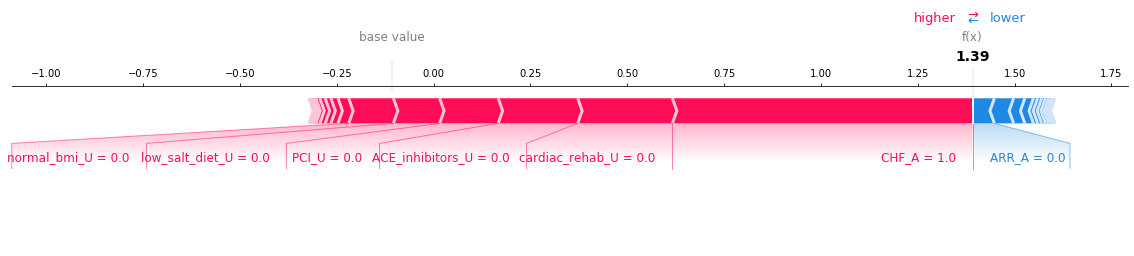

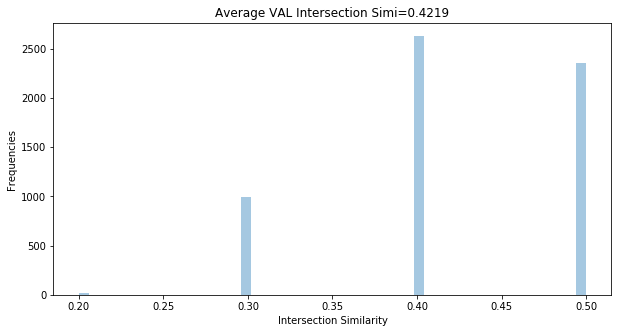

Visualizing SHAP values of TEST examples...


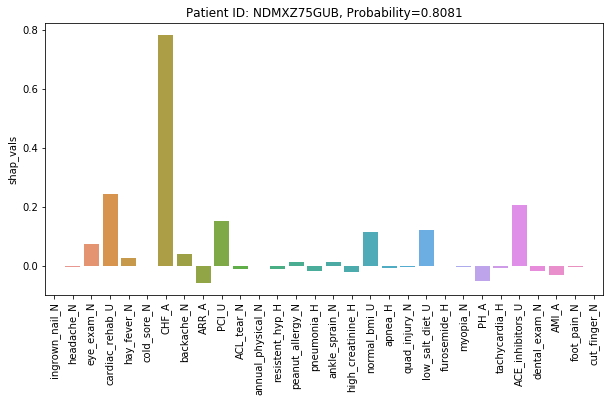

[1, 1, 3, 0, 3, 1, 1, 2, 0, 0, 0, 2, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0]


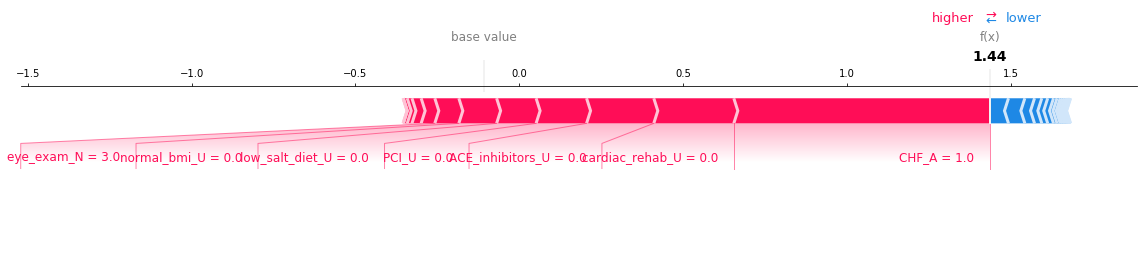

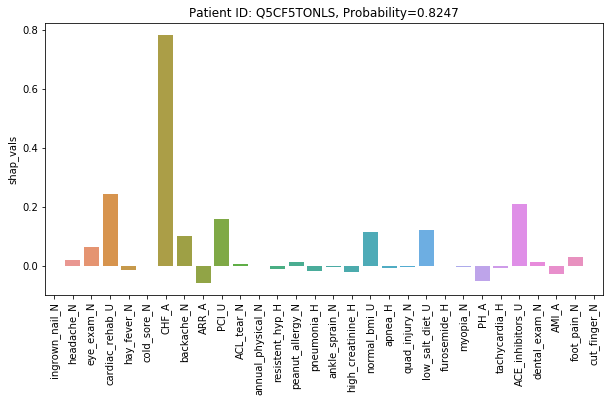

[1, 2, 3, 0, 1, 2, 1, 5, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 2, 0, 4, 0]


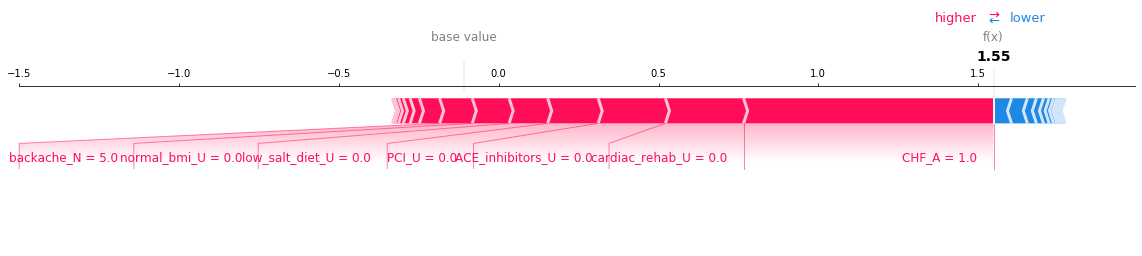

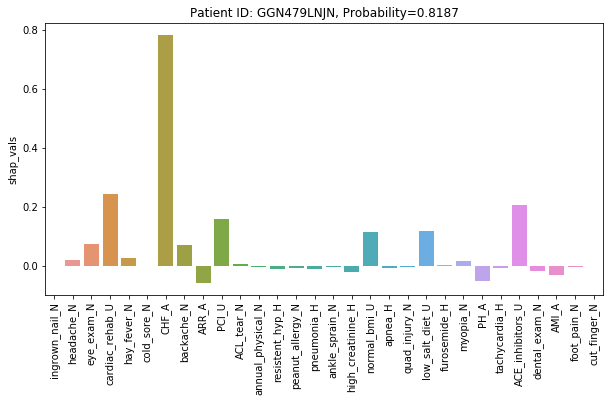

[1, 3, 3, 0, 3, 1, 1, 3, 0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0]


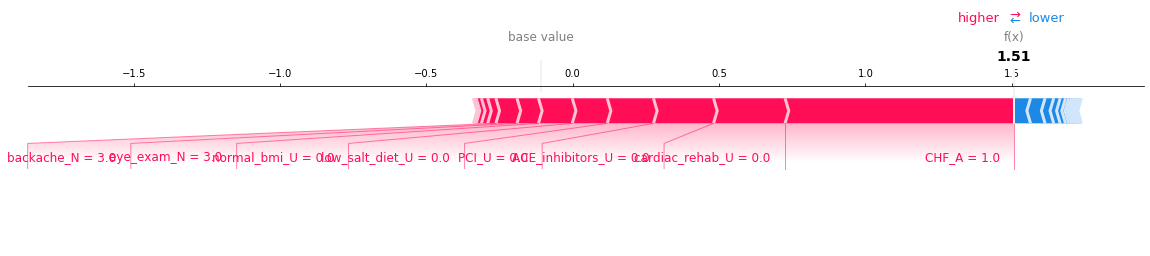

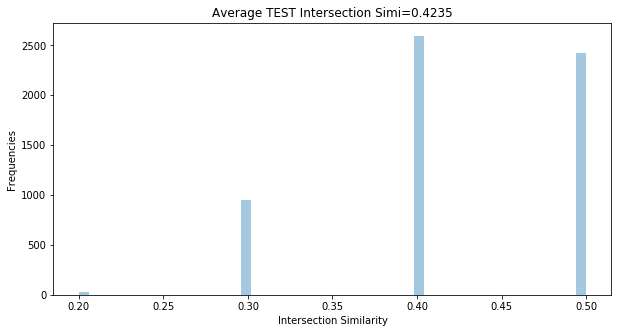

Finally computing and visualizing the global feature importance of the best model....


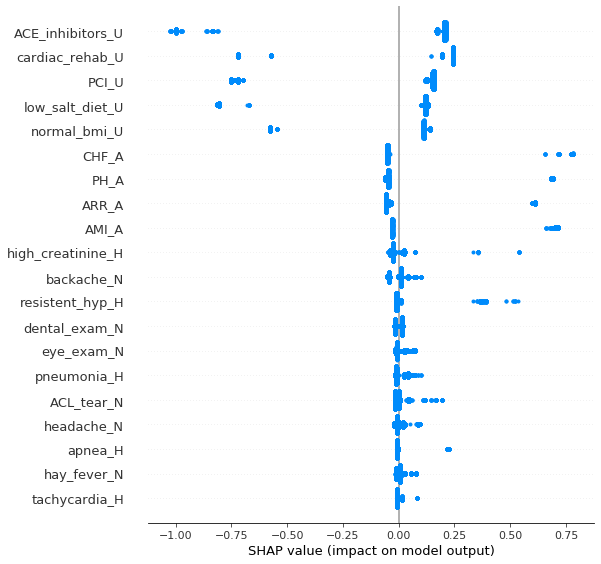

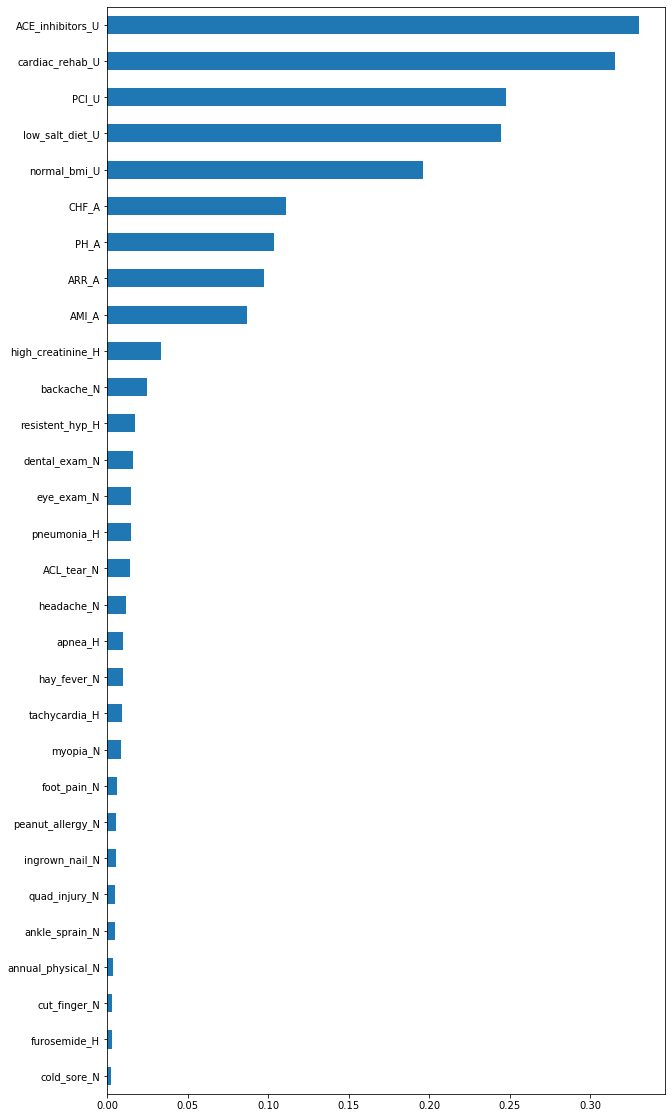

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-32-48-155...
Train AUC= 0.8935, Val AUC=0.8930, Test AUC=0.8995
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-32-48-155.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-32-48-155.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.3979, Test Int. Simi=0.3975
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


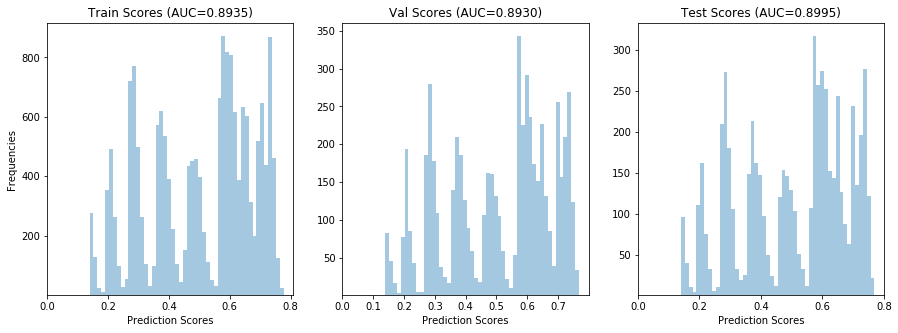

Visualizing SHAP values of VAL examples...


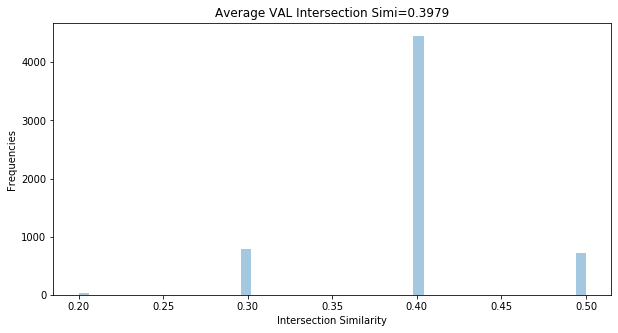

Visualizing SHAP values of TEST examples...


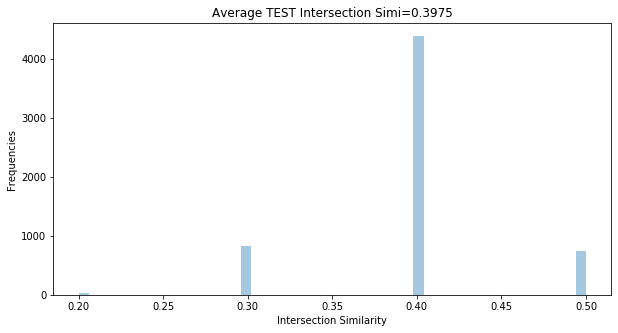

Finally computing and visualizing the global feature importance of the best model....


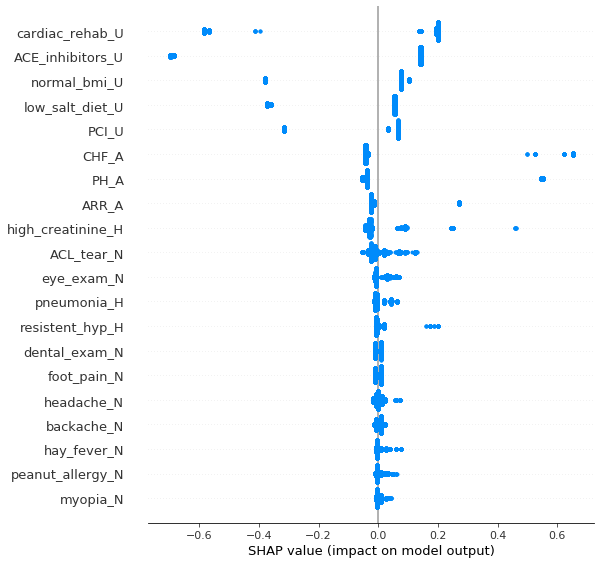

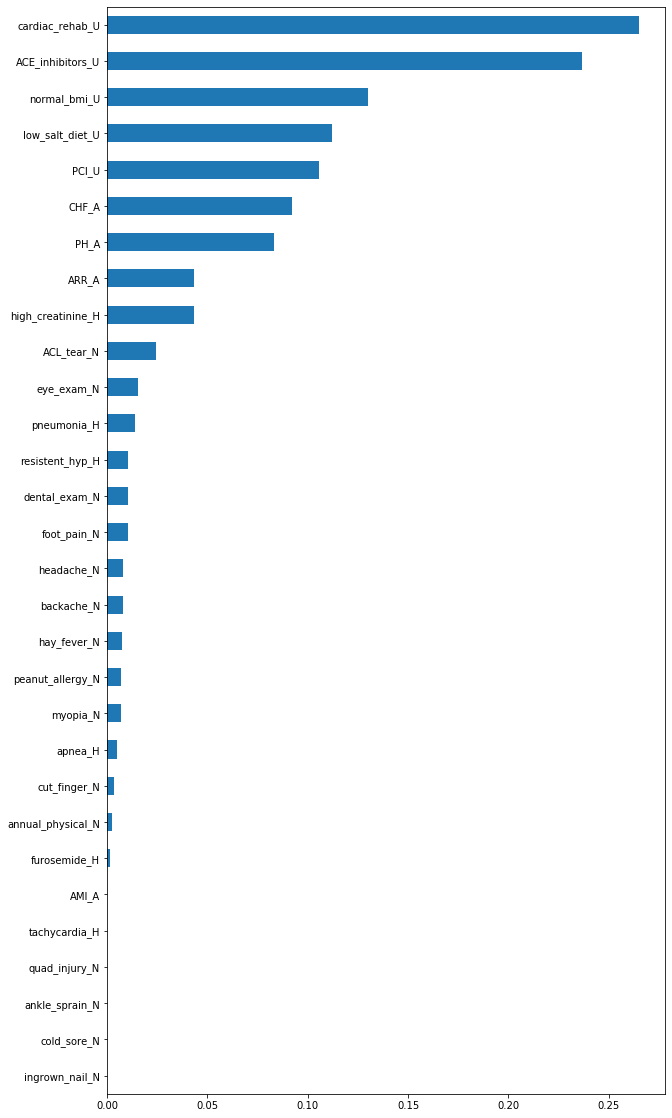

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-36-30-409...
Train AUC= 0.8878, Val AUC=0.8873, Test AUC=0.8927
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-36-30-409.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-36-30-409.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.4807, Test Int. Simi=0.4806
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


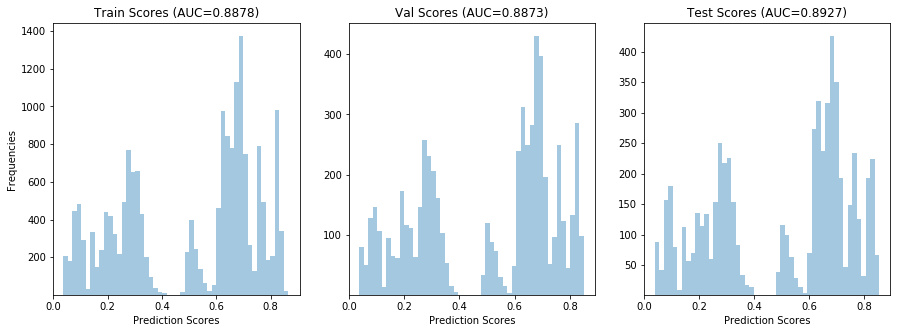

Visualizing SHAP values of VAL examples...


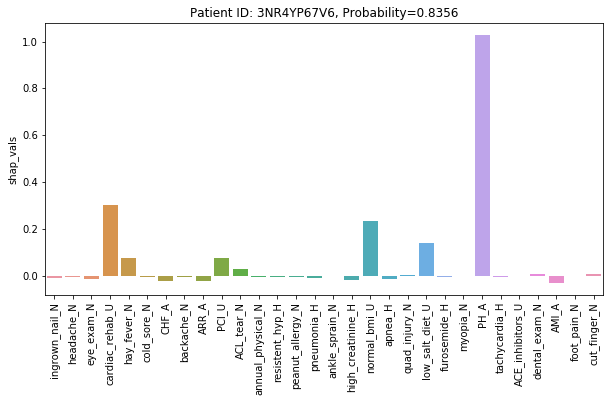

[1, 1, 0, 0, 4, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]


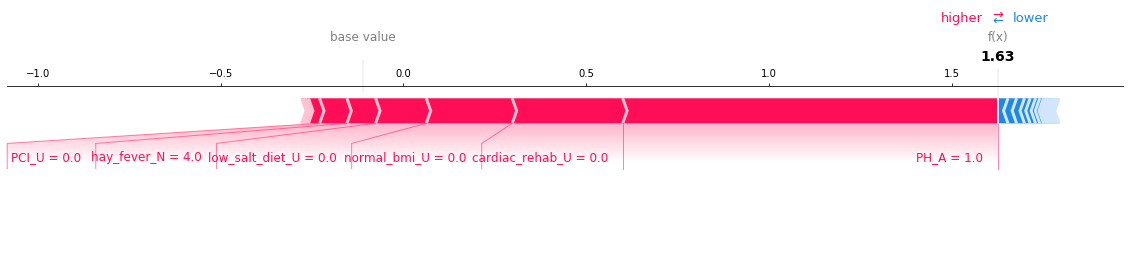

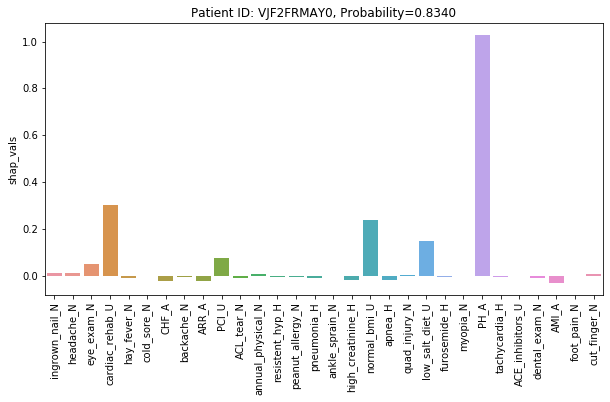

[0, 3, 3, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]


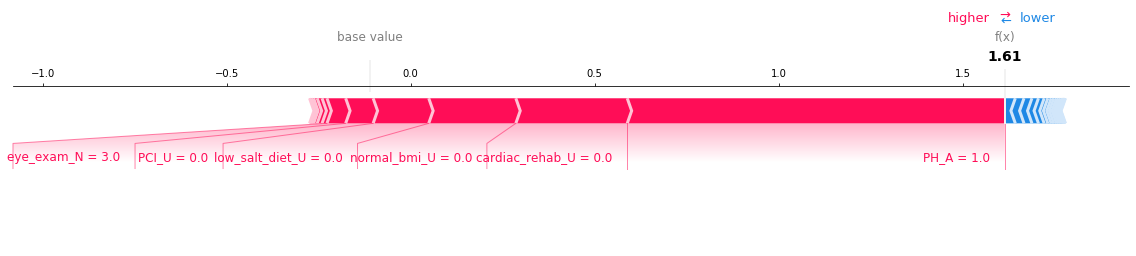

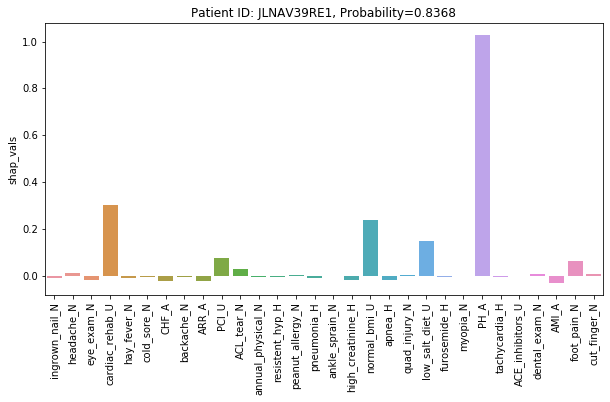

[2, 3, 1, 0, 1, 3, 0, 1, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 4, 1]


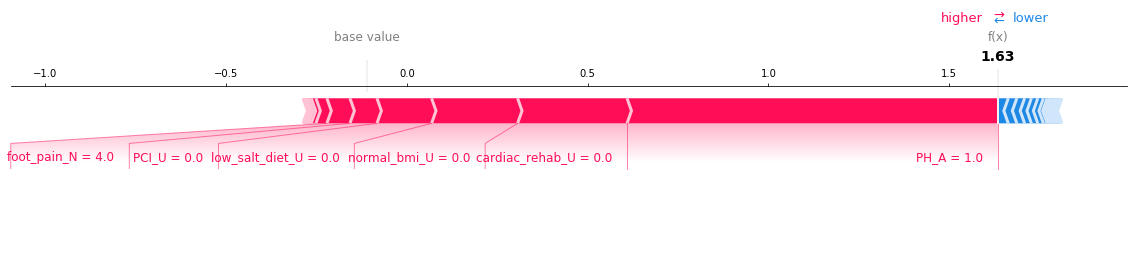

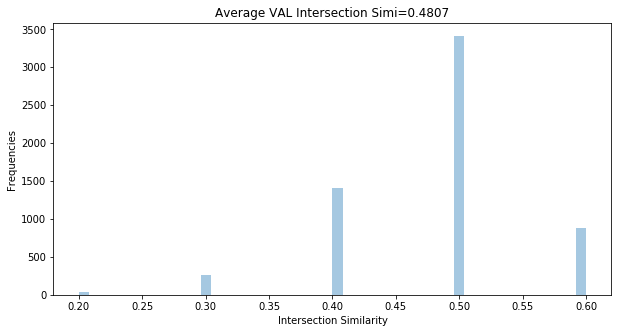

Visualizing SHAP values of TEST examples...


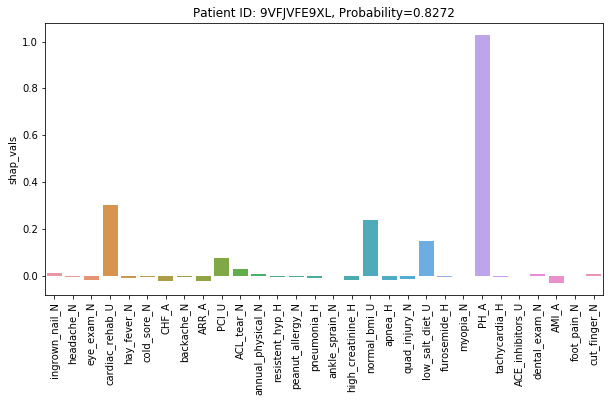

[0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0]


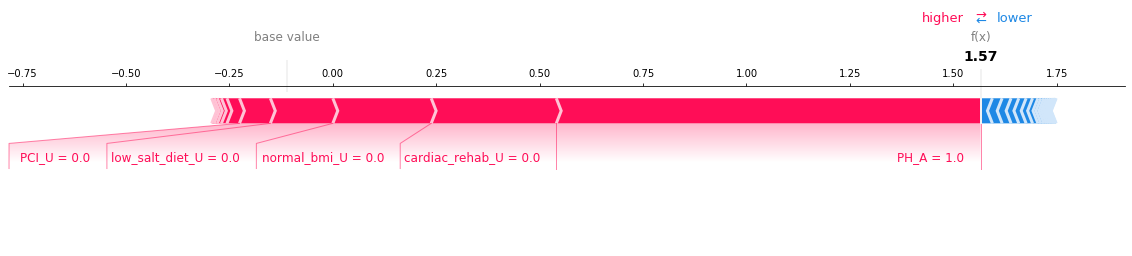

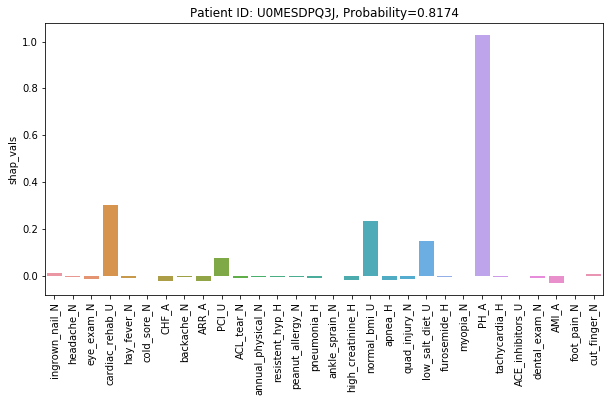

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


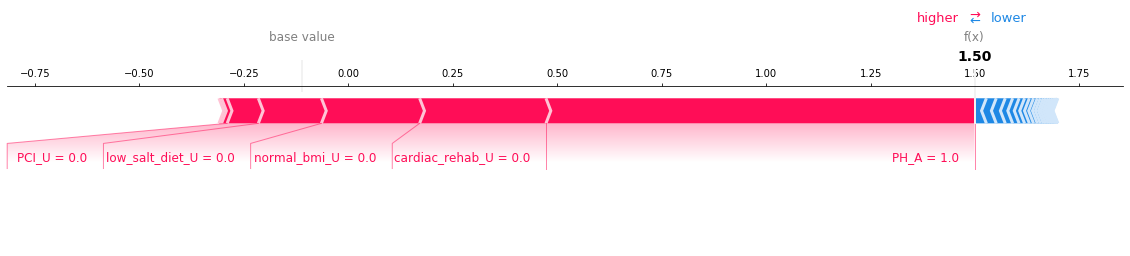

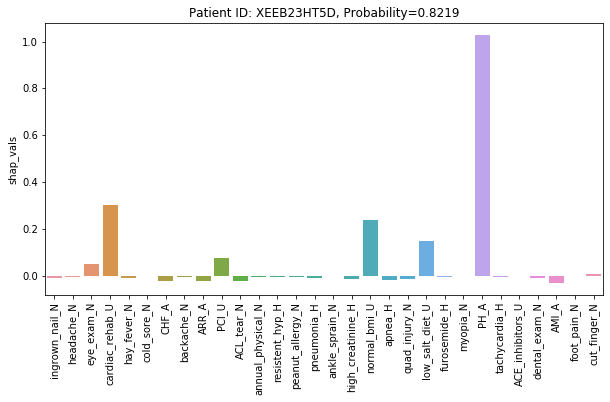

[1, 1, 4, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1]


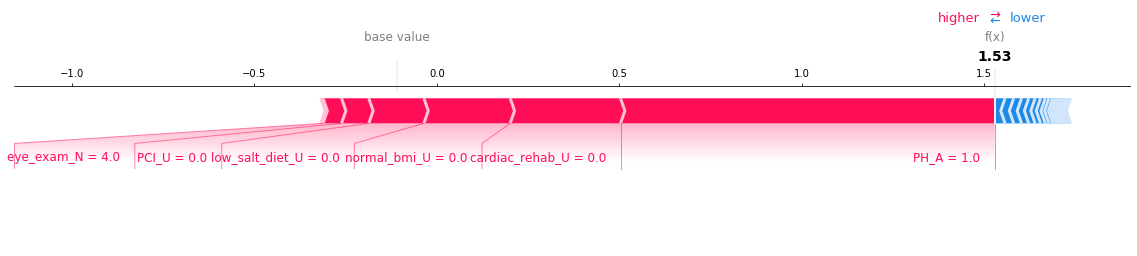

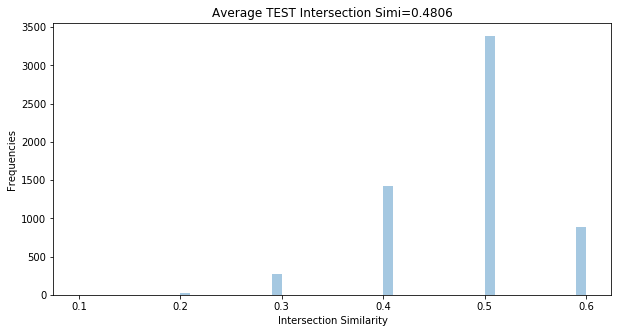

Finally computing and visualizing the global feature importance of the best model....


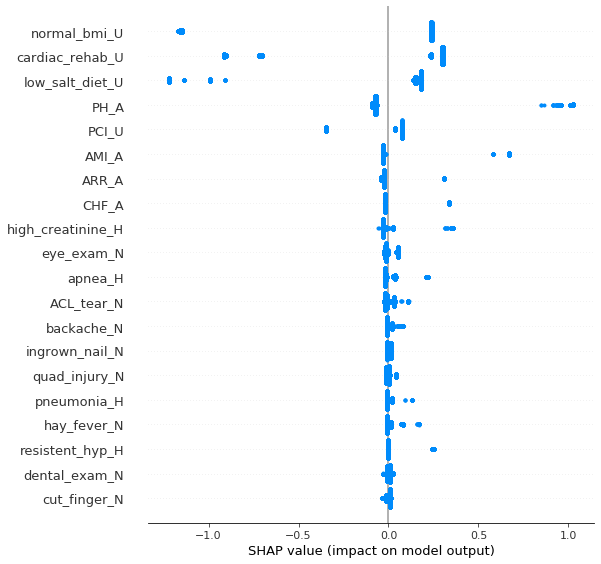

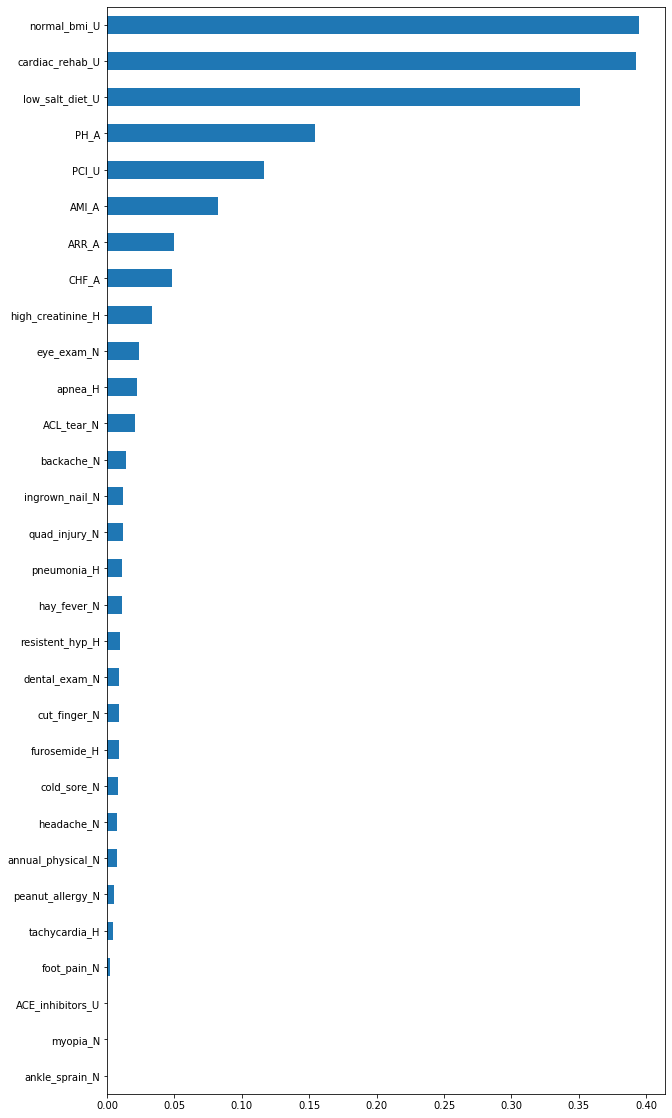

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-40-12-595...
Train AUC= 0.8822, Val AUC=0.8841, Test AUC=0.8857
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-40-12-595.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-40-12-595.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.4600, Test Int. Simi=0.4605
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


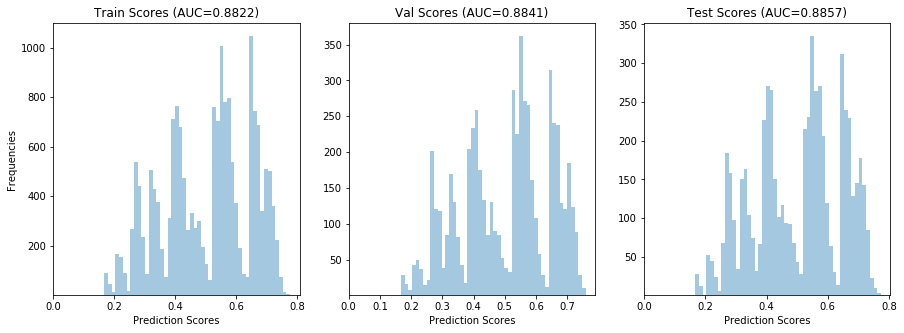

Visualizing SHAP values of VAL examples...


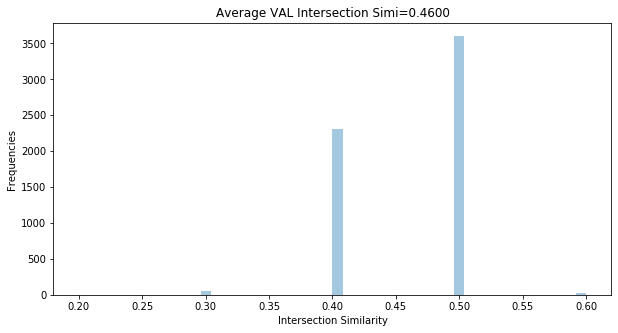

Visualizing SHAP values of TEST examples...


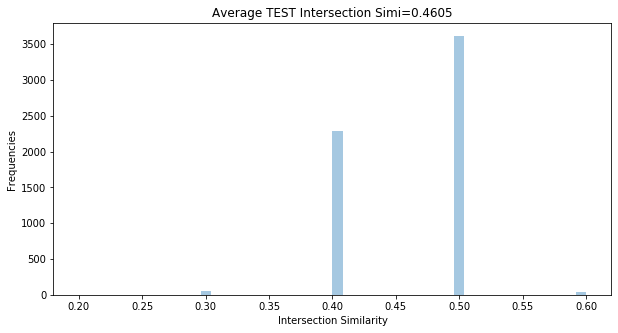

Finally computing and visualizing the global feature importance of the best model....


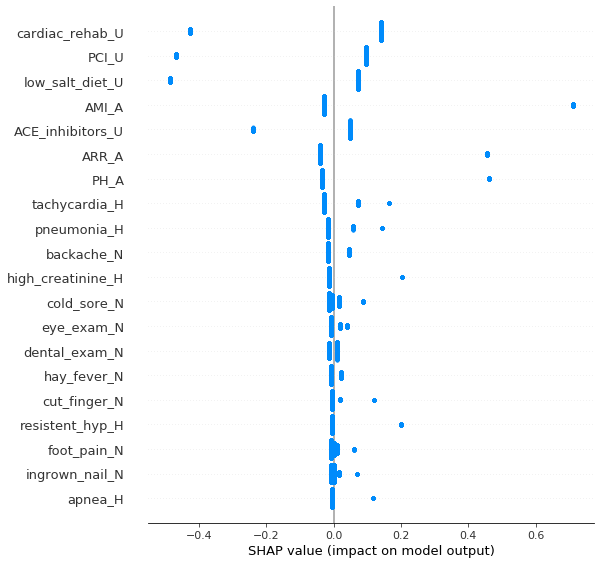

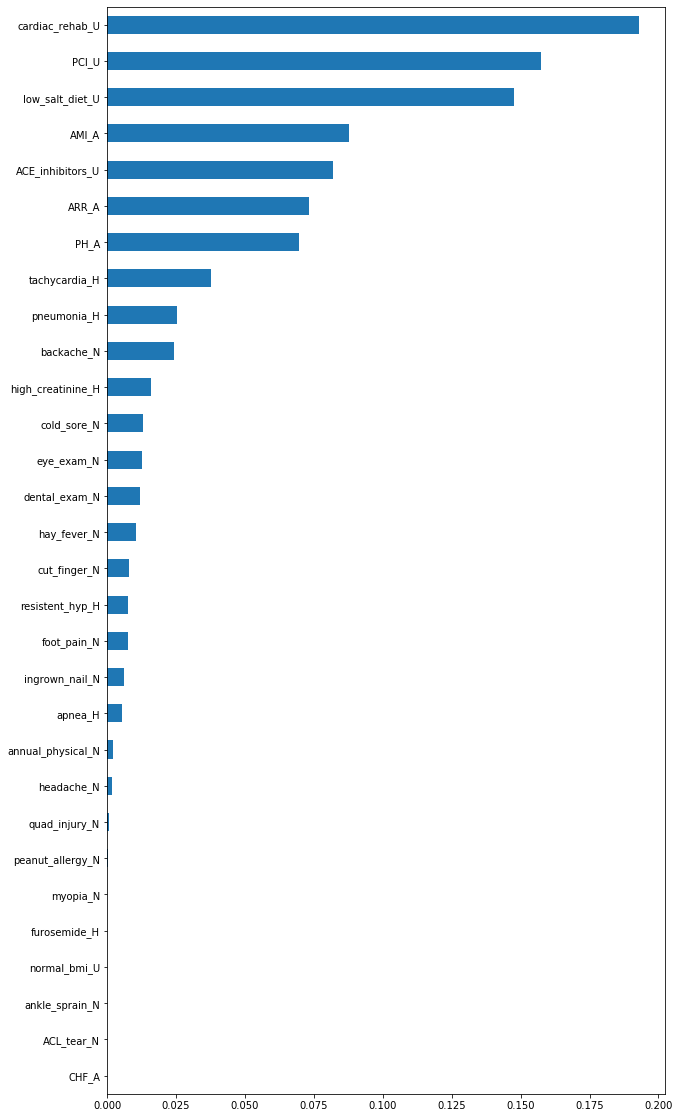

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-43-54-745...
Train AUC= 0.8800, Val AUC=0.8783, Test AUC=0.8798
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-43-54-745.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-43-54-745.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.4802, Test Int. Simi=0.4807
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


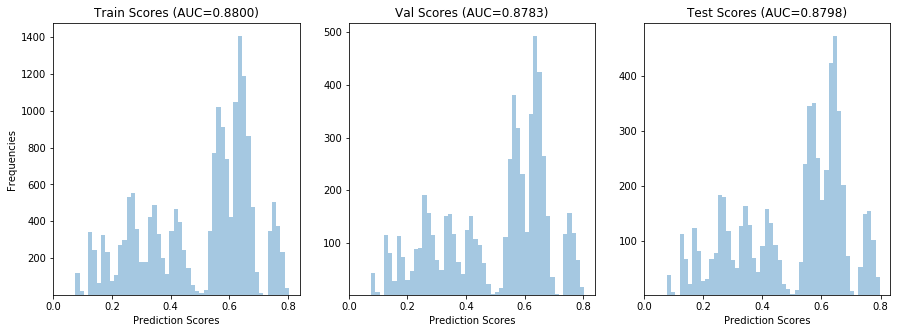

Visualizing SHAP values of VAL examples...


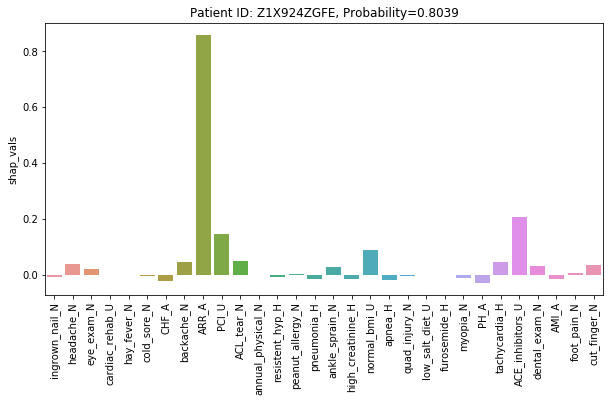

[3, 3, 2, 0, 0, 1, 0, 2, 1, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 3]


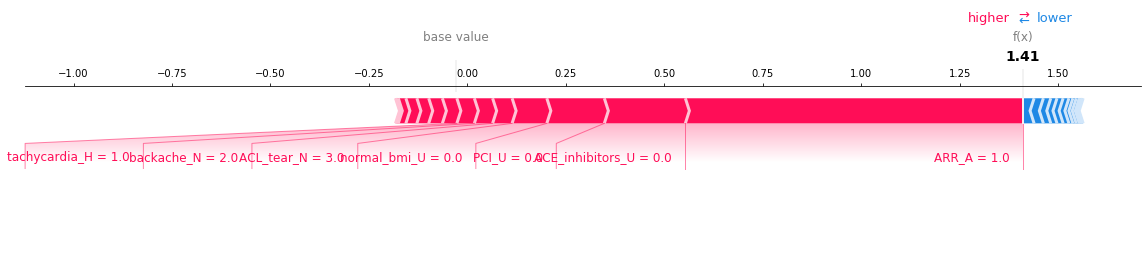

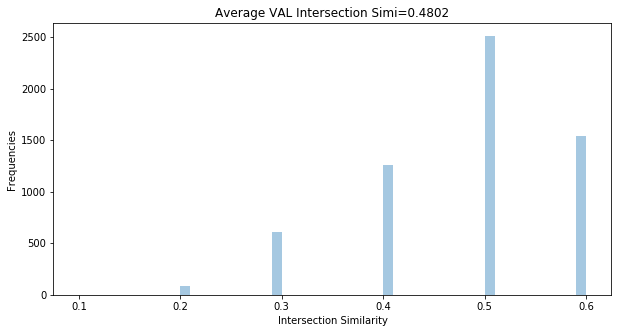

Visualizing SHAP values of TEST examples...


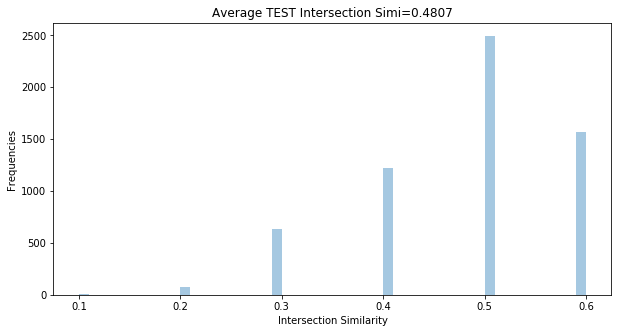

Finally computing and visualizing the global feature importance of the best model....


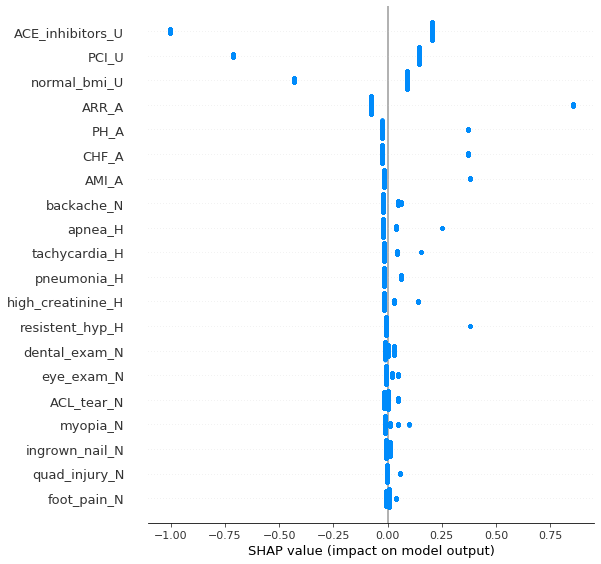

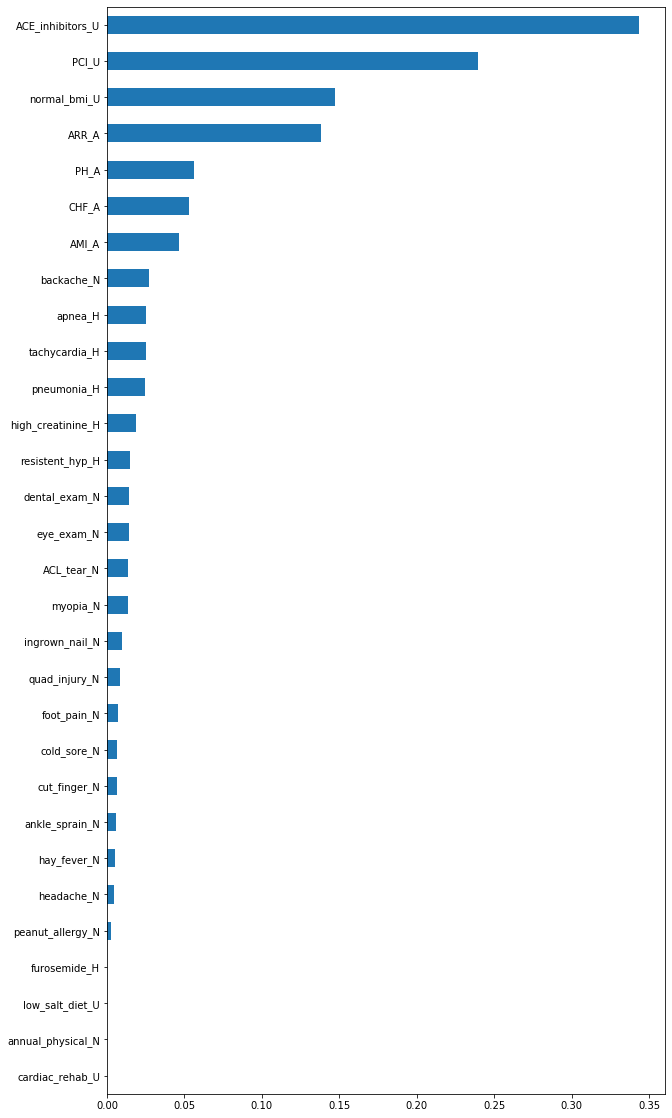

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-47-37-276...
Train AUC= 0.8738, Val AUC=0.8711, Test AUC=0.8815
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-47-37-276.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-47-37-276.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.3064, Test Int. Simi=0.3065
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


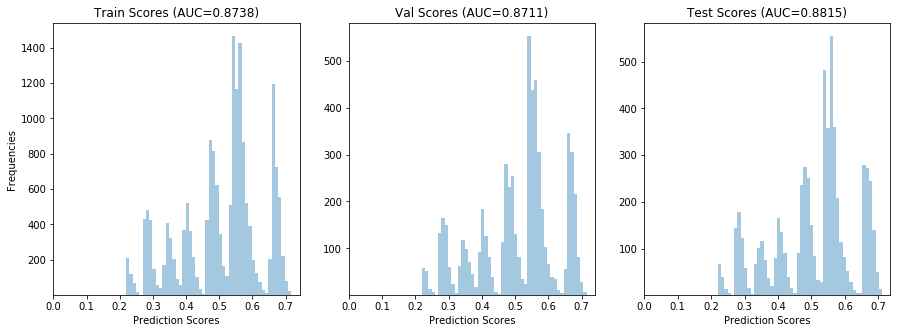

Visualizing SHAP values of VAL examples...


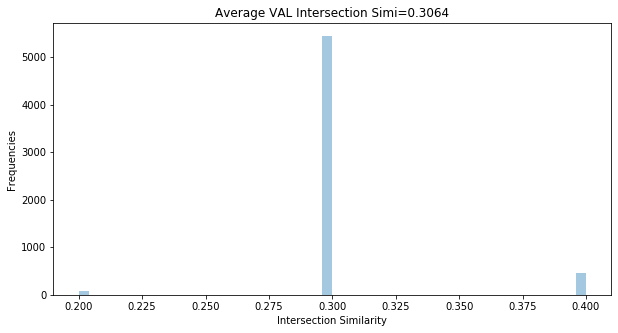

Visualizing SHAP values of TEST examples...


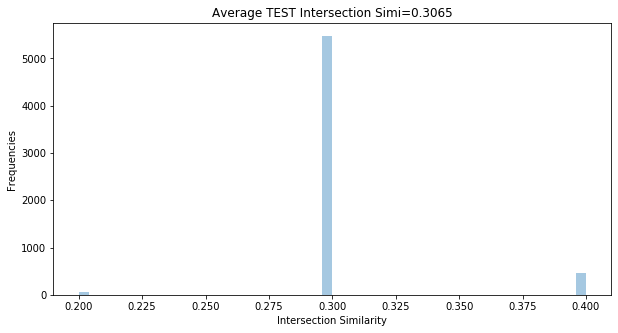

Finally computing and visualizing the global feature importance of the best model....


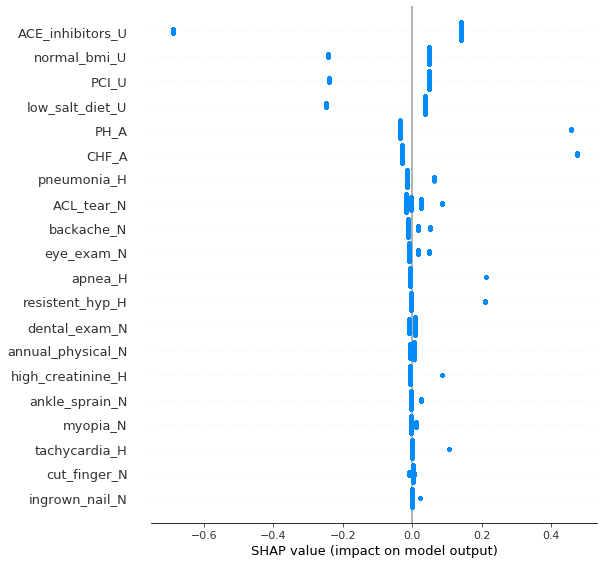

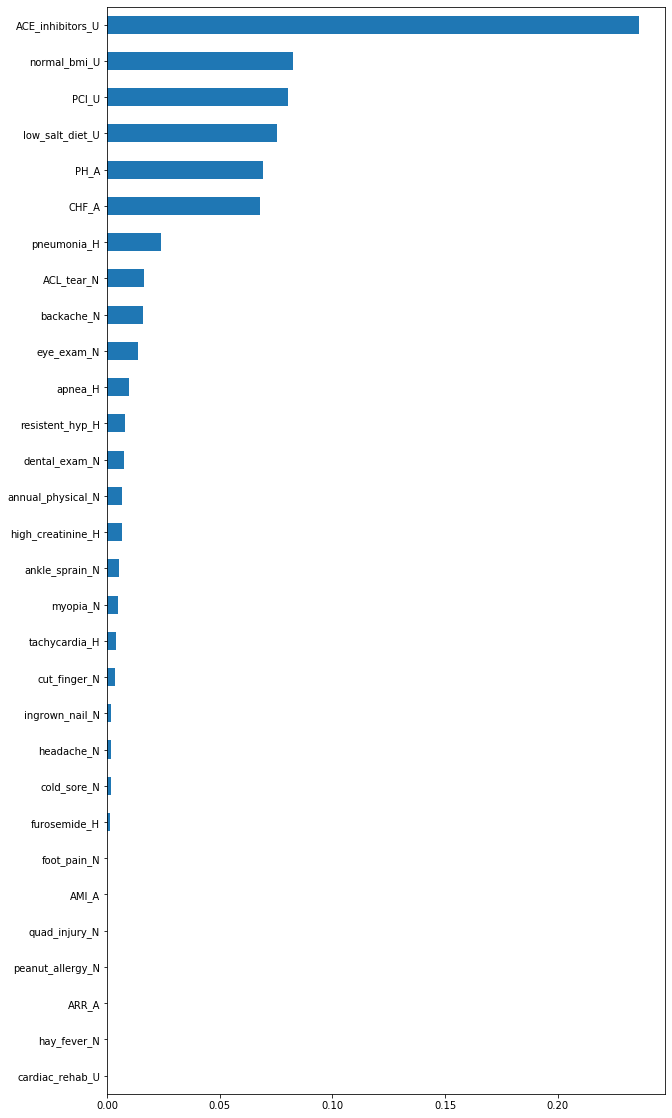

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-52-20-485...
Train AUC= 0.8633, Val AUC=0.8566, Test AUC=0.8626
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-52-20-485.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-52-20-485.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.5967, Test Int. Simi=0.5992
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


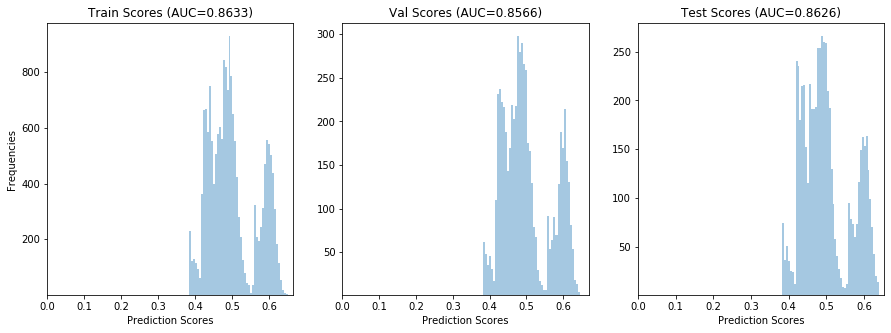

Visualizing SHAP values of VAL examples...


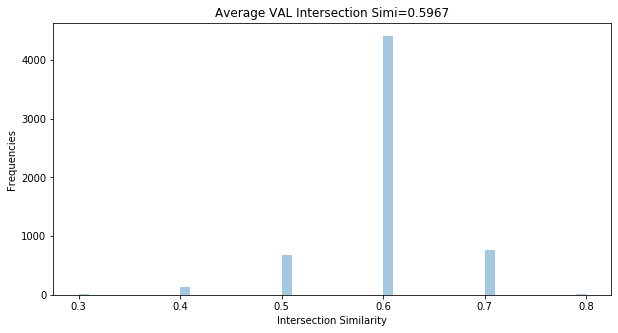

Visualizing SHAP values of TEST examples...


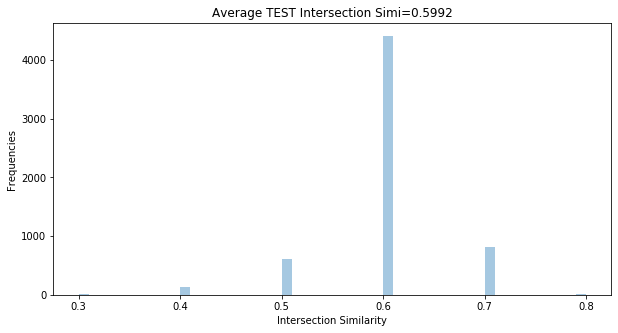

Finally computing and visualizing the global feature importance of the best model....


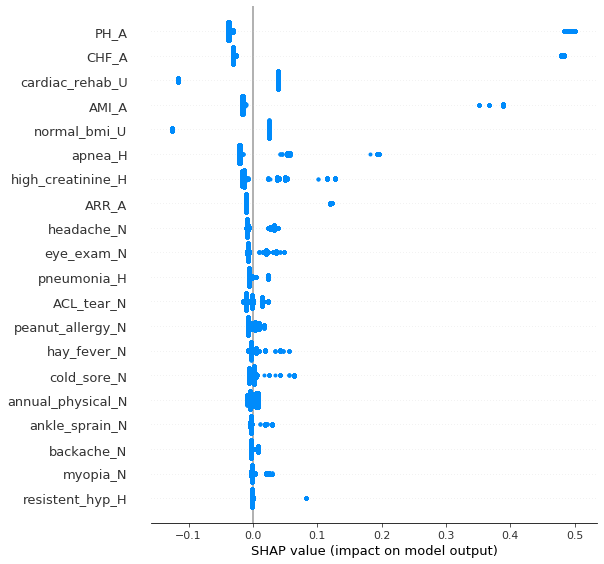

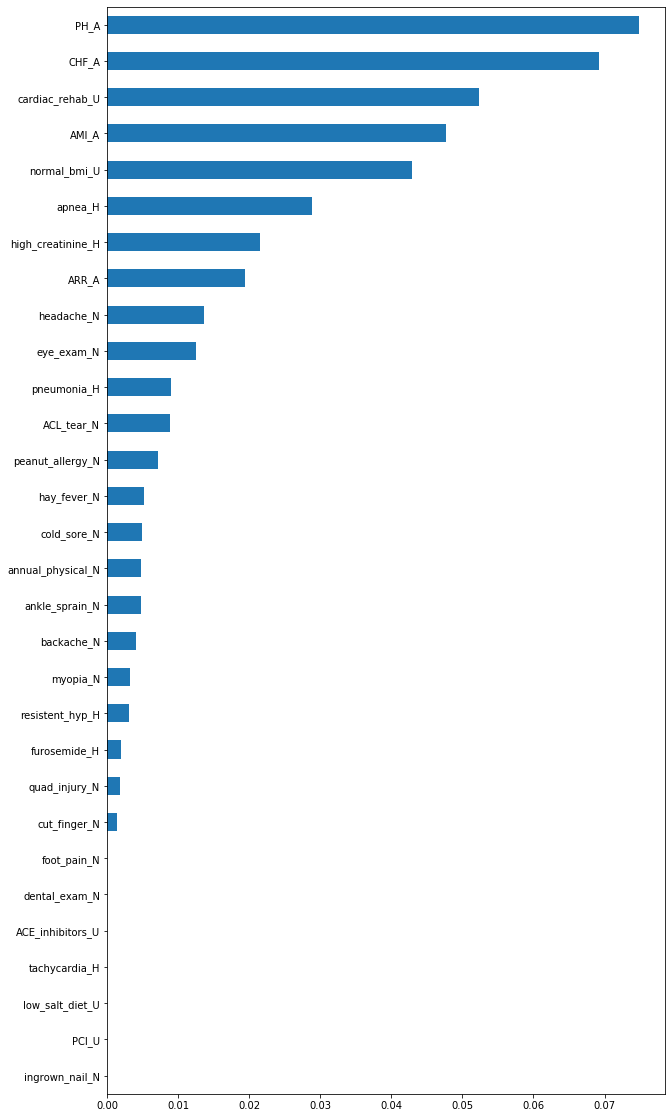

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-56-34-691...
Train AUC= 0.8434, Val AUC=0.8425, Test AUC=0.8472
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-56-34-691.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-56-34-691.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.2536, Test Int. Simi=0.2555
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


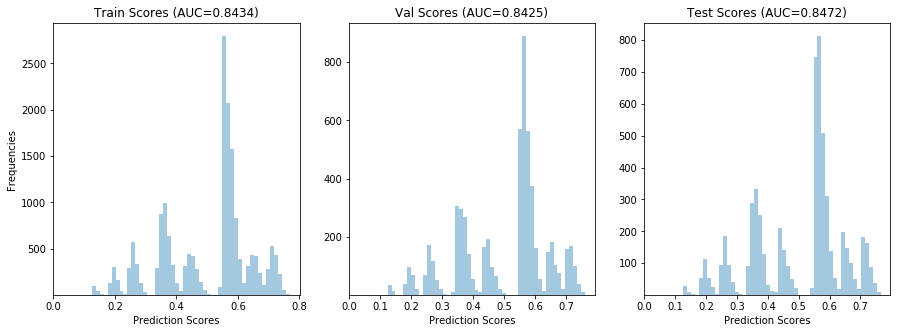

Visualizing SHAP values of VAL examples...


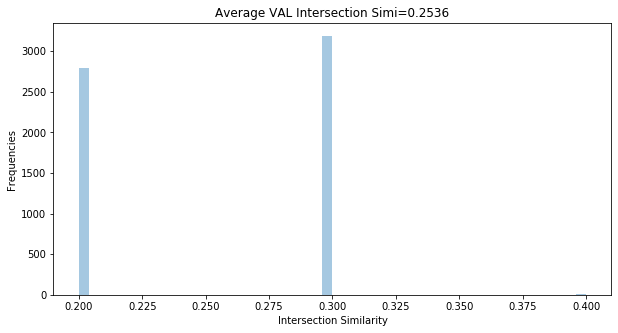

Visualizing SHAP values of TEST examples...


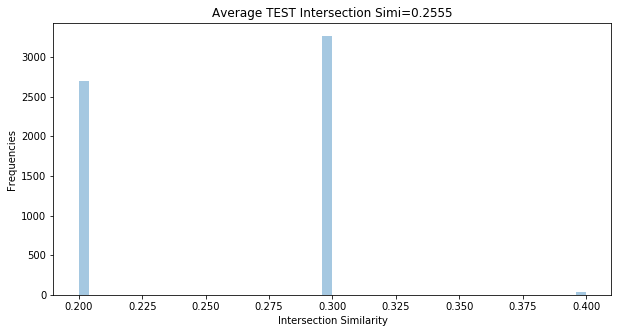

Finally computing and visualizing the global feature importance of the best model....


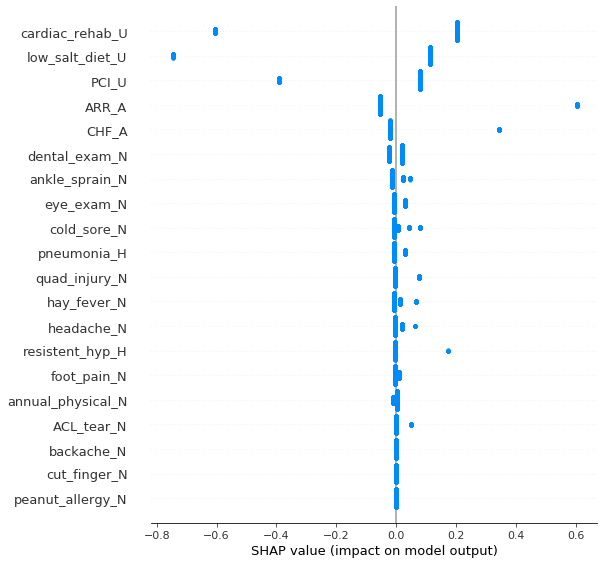

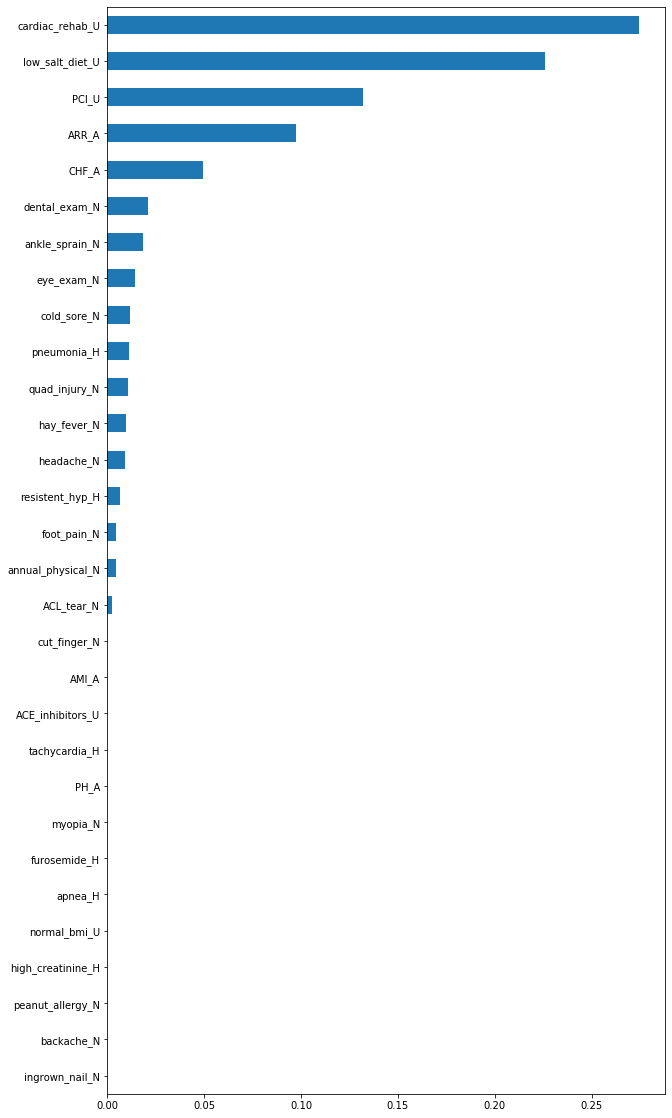

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-59-46-657...
Train AUC= 0.8449, Val AUC=0.8430, Test AUC=0.8392
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-59-46-657.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-19-59-46-657.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.3814, Test Int. Simi=0.3813
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


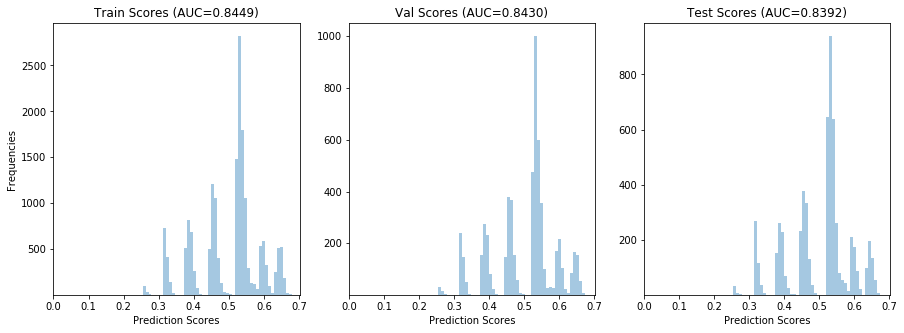

Visualizing SHAP values of VAL examples...


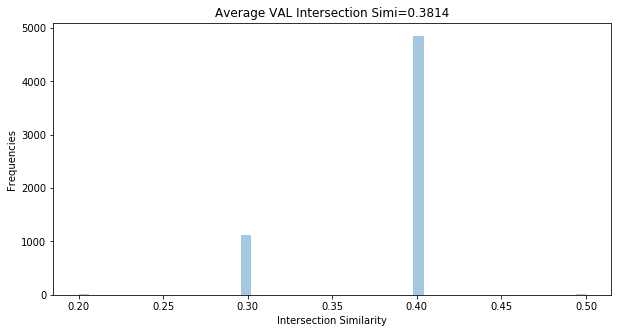

Visualizing SHAP values of TEST examples...


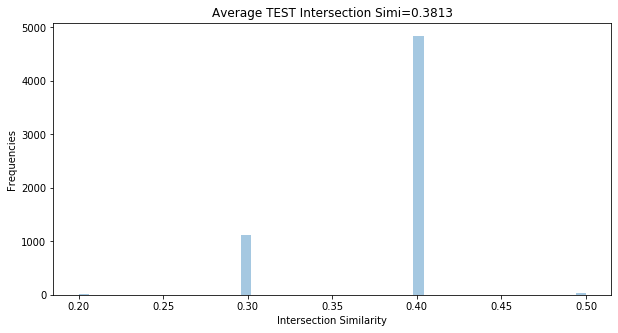

Finally computing and visualizing the global feature importance of the best model....


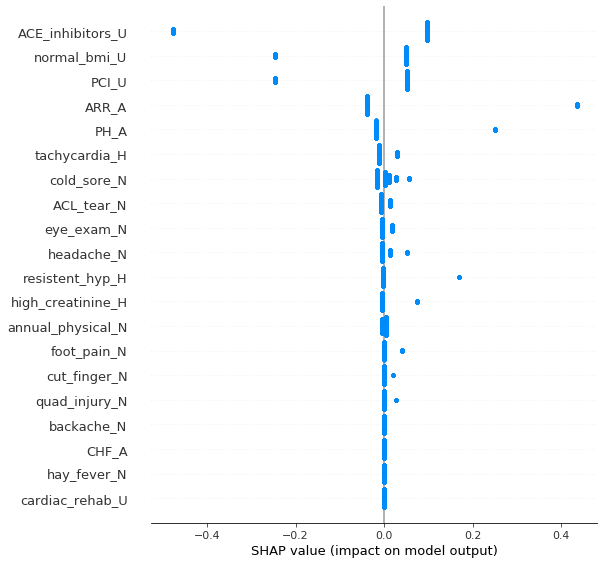

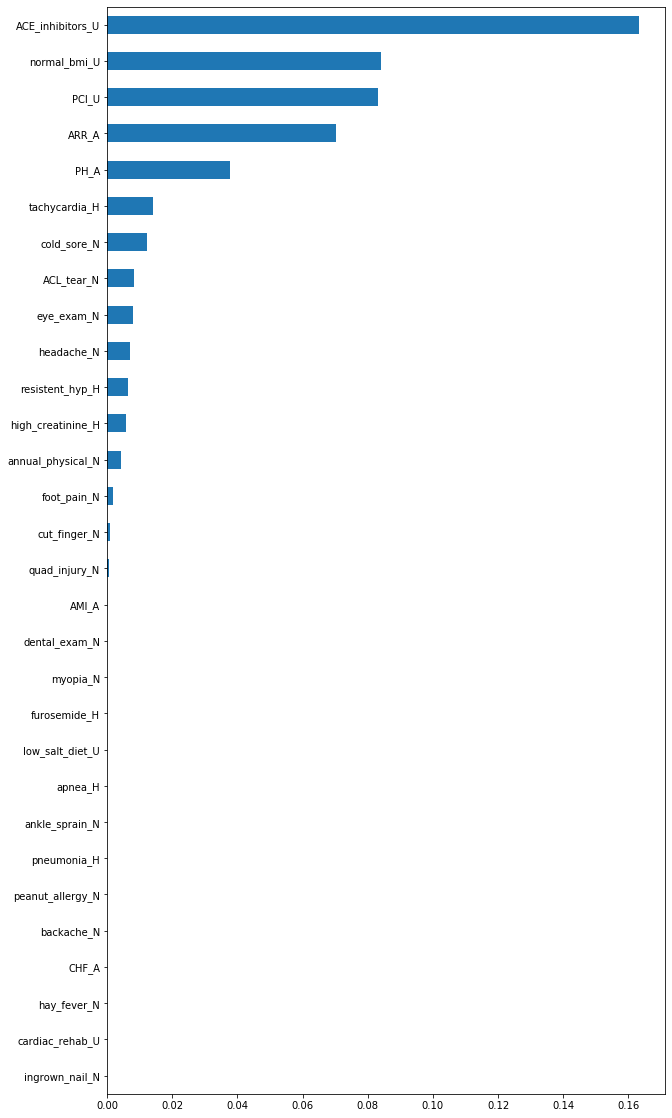

All tasks SUCCESSFULLY completed!
Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-20-03-59-270...
Train AUC= 0.7580, Val AUC=0.7571, Test AUC=0.7536
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-20-03-59-270.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-20-03-59-270.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.6014, Test Int. Simi=0.6011
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


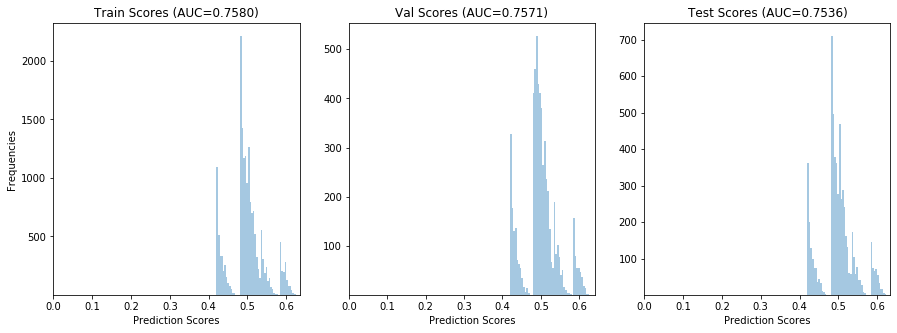

Visualizing SHAP values of VAL examples...


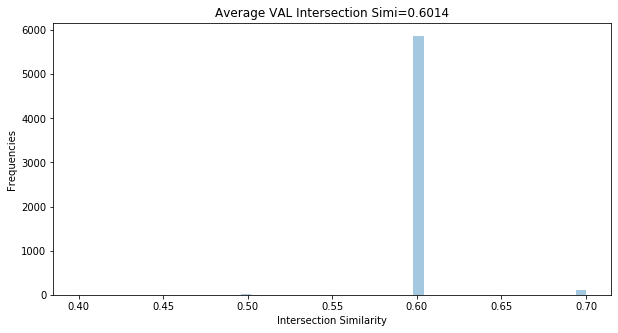

Visualizing SHAP values of TEST examples...


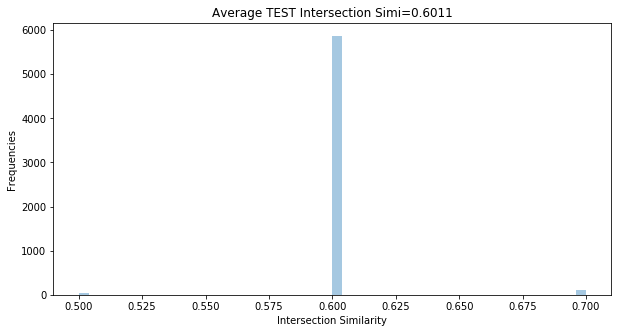

Finally computing and visualizing the global feature importance of the best model....


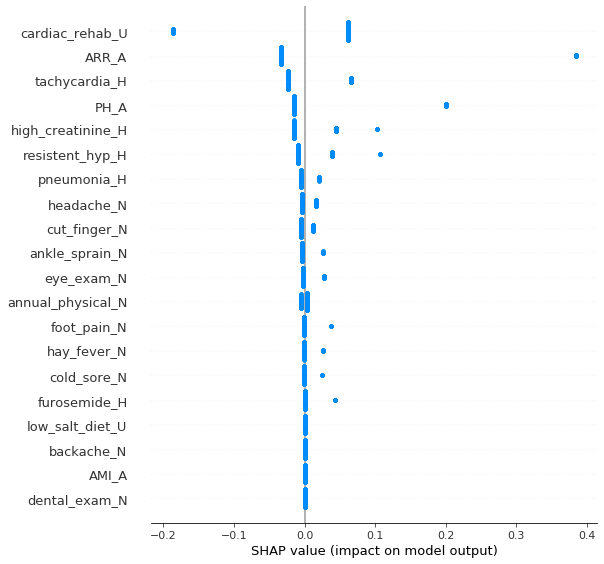

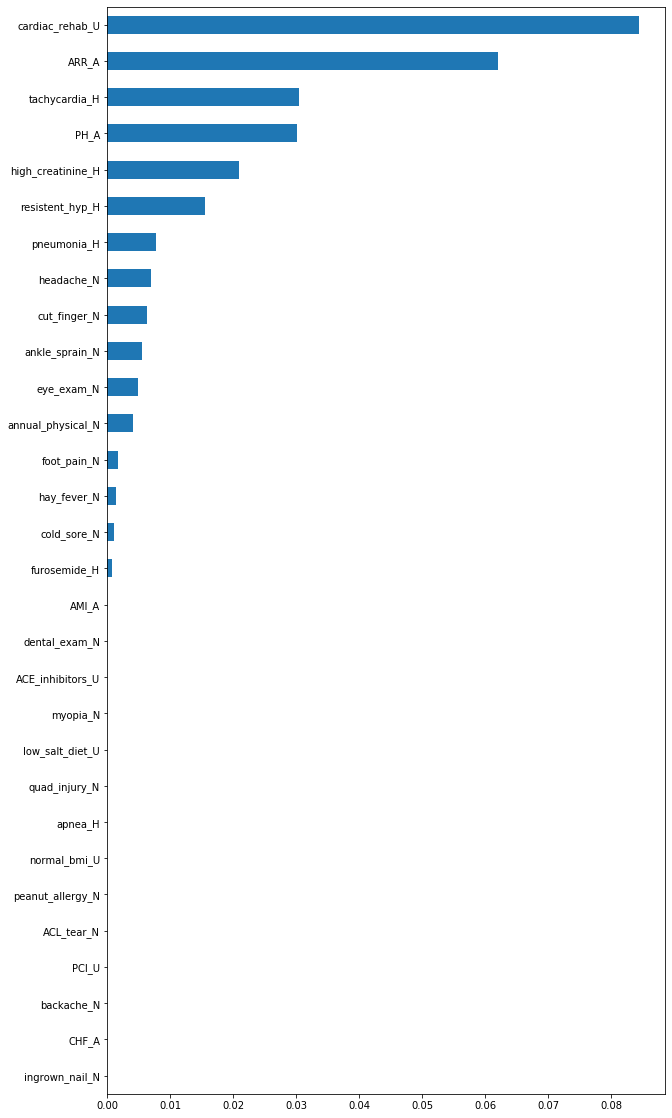

All tasks SUCCESSFULLY completed!


In [158]:
results = df_hpo.apply(
    compute_shap,
    args=(
        shap_save_path_pattern,
        df_train,
        df_val,
        df_test,
        SHAP_SCORE_ABSOLUTE,
        TEST_POSITIVE_ONLY,
        SAVE_SHAP_OUTPUT,
        True,  # Visualize
    ),
    axis=1,
)

In [159]:
def add_shap_results(df0, results, output_path=None):
    """Add shap performance to HPO results dataframe."""
    df = df0.copy(deep=True)
    df["val_AUC"] = [result[0] for result in results]
    df["test_AUC"] = [result[1] for result in results]
    df["val_Intersection_Sim"] = [result[2] for result in results]
    df["test_Intersection_Sim"] = [result[3] for result in results]
    df.to_csv(output_path, index=False)
    return df


def get_best_model_info(df):
    """Get best model path based on its Intersection Sim index."""
    best_idx = df[["val_Intersection_Sim"]].idxmax().tolist()[0]
    best_df_row = df.iloc[best_idx]
    return best_df_row

In [160]:
df_hpo = add_shap_results(df_hpo, results, output_path=output_results_path)
df_hpo.head()

,alpha,colsample_bylevel,colsample_bynode,colsample_bytree,eta,gamma,lambda,max_delta_step,max_depth,min_child_weight,...,subsample,model,dataset,seq_len,s3_path,local_path,val_AUC,test_AUC,val_Intersection_Sim,test_Intersection_Sim
0,0.084537,0.170514,0.284080,0.580087,0.230492,0.000000,6.960190,0.0,2.0,3.490784,...,0.688921,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...,0.894889,0.899628,0.421917,0.423467
1,0.088697,0.159328,0.283506,0.587418,0.279165,0.426940,37.718505,0.0,2.0,3.375425,...,0.682185,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...,0.893024,0.899478,0.397850,0.397467
2,0.835199,0.108679,0.180286,0.564033,0.298695,1.434551,17.296006,3.0,2.0,1.382886,...,0.640791,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...,0.887319,0.892661,0.480733,0.480617
3,0.060123,0.169096,0.214744,0.692486,0.218188,0.736939,14.333237,1.0,1.0,4.286682,...,0.551523,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...,0.884078,0.885714,0.459950,0.460500
4,0.234247,0.183984,0.157849,0.595210,0.290516,0.237530,29.179551,2.0,1.0,1.853467,...,0.638667,xgb,Synthetic-events,30,s3://merck-paper-bucket/Synthetic-events/ExpII...,output/ExpIII/30/05/xgb/models/sagemaker-xgboo...,0.878336,0.879832,0.480217,0.480717


In [161]:
# Get the best xgb model
best_model_info = xgb_utils.get_best_model_info(df_hpo)

Processing for training job name = output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-20-03-59-270...
Train AUC= 0.7580, Val AUC=0.7571, Test AUC=0.7536
Computing SHAP values...
saved ./output/ExpIII/30/05/xgb/shap/val_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-20-03-59-270.pkl pickle..
saved ./output/ExpIII/30/05/xgb/shap/test_shap_output/ExpIII/30/05/xgb/models/sagemaker-xgboost-2021-01-23-20-03-59-270.pkl pickle..
Computing Intersection Similarity...
Val Int. Simi=0.6014, Test Int. Simi=0.6011
****************************************************************************************************
Ploting Histograms of Train/Val/Test Predicted Scores...


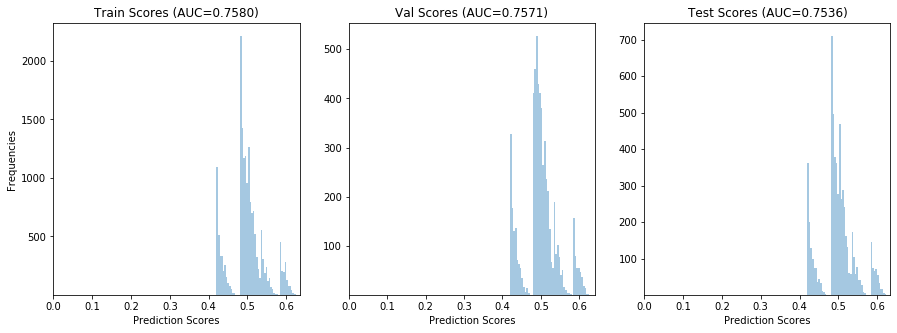

Visualizing SHAP values of VAL examples...


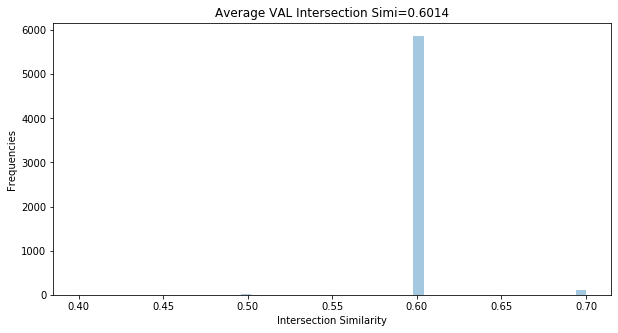

Visualizing SHAP values of TEST examples...


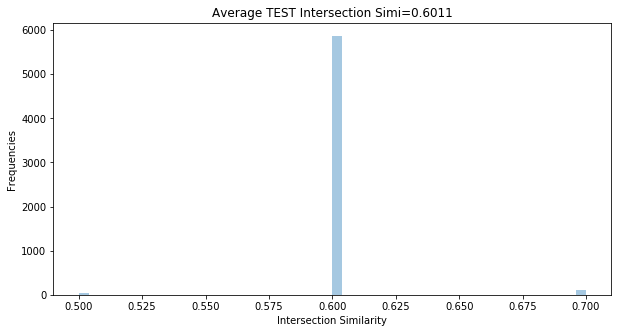

Finally computing and visualizing the global feature importance of the best model....


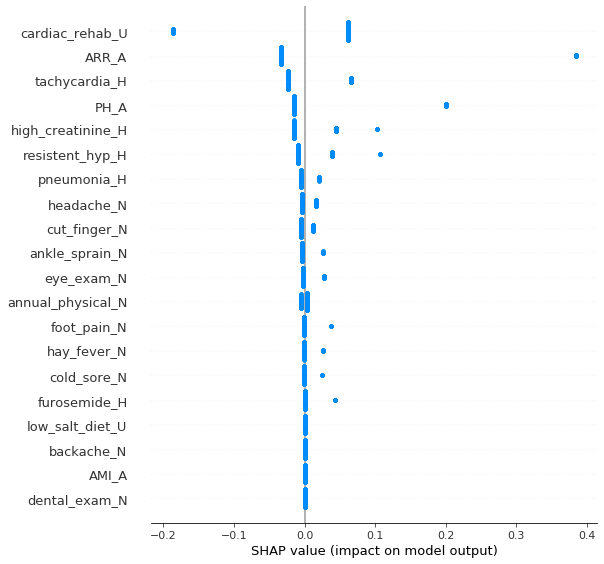

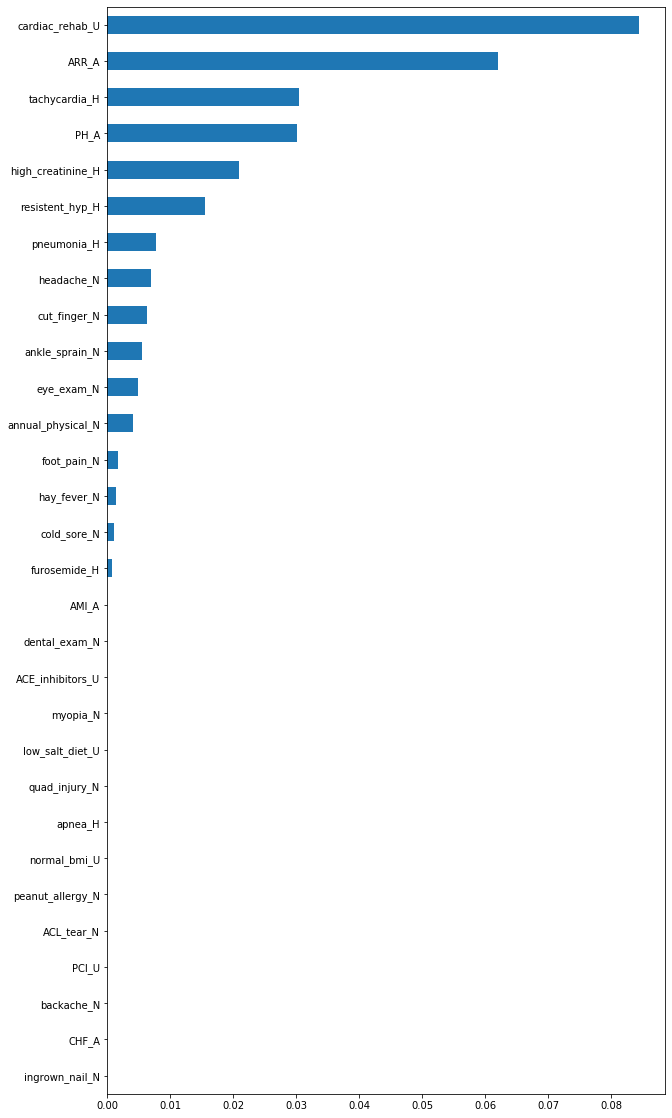

All tasks SUCCESSFULLY completed!


In [162]:
result = compute_shap(
    best_model_info,
    shap_save_path_pattern,
    df_train,
    df_val,
    df_test,
    absolute=True,
    test_positive_only=TEST_POSITIVE_ONLY,
    save_output=SAVE_SHAP_OUTPUT,
    visualize=True,
)

### XGB Built-in Feature Importances

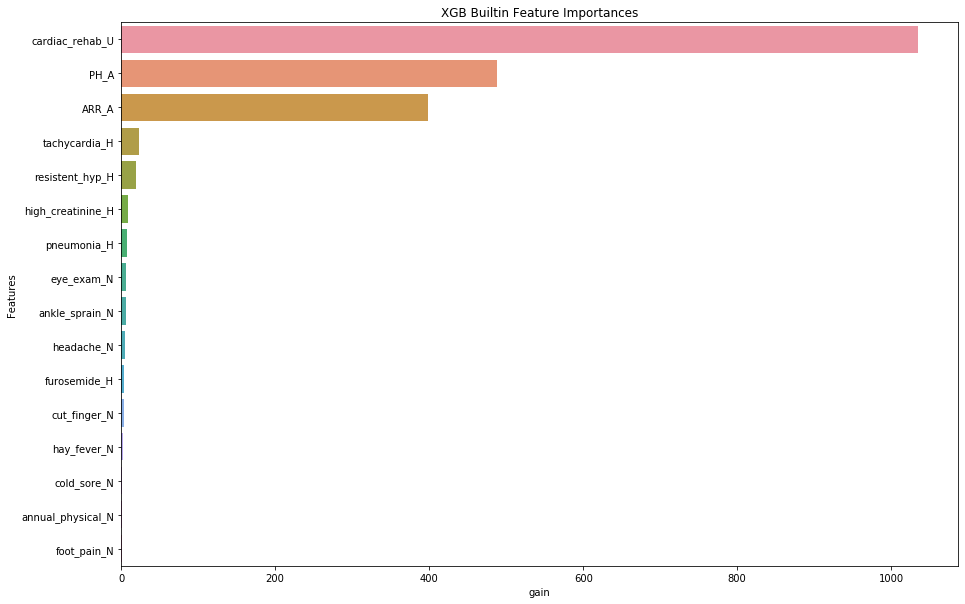

In [163]:
importance_type = "gain"  # Possible values: weight/gain/cover

model_path = best_model_info["local_path"]

xgb_model = xgb_utils.load_model(model_path, remove=False)
importances0 = xgb_model.get_score(importance_type=importance_type)

# Get mapping between the model and actual feature names
feature_names = df_train.columns.tolist()[1:-1]
mappings = dict(zip(xgb_model.feature_names, feature_names))

importances = {}
for k, v in importances0.items():
    importances[mappings[k]] = v
importances = dict(sorted(importances.items(), key=lambda item: item[1], reverse=True))

# Plot the feature importances
plt.figure(figsize=(15, 10))
ax = sns.barplot(
    y=list(range(len(list(importances.keys())))),
    x=list(importances.values()),
    orient="h",
)
z = ax.set_yticklabels(list(importances.keys()), rotation=0)
plt.title("XGB Builtin Feature Importances")
plt.xlabel(importance_type)
plt.ylabel("Features")
plt.show()

In [164]:
##Get distribution of dataset

In [165]:
df_tr = pd.read_csv(train_data_path)
df_va = pd.read_csv(valid_data_path)
df_te = pd.read_csv(test_data_path)
print(df_tr.shape, df_va.shape, df_te.shape)

(18000, 33) (6000, 33) (6000, 33)


In [166]:
print(df_tr.shape)
df_tr.head(2)

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2710,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,backache_N,tachycardia_H,hay_fever_N,dental_exam_N,foot_pain_N,ingrown_nail_N,eye_exam_N,quad_injury_N,0,40S1HVN02C
1,2265,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ACL_tear_N,myopia_N,cut_finger_N,cold_sore_N,normal_bmi_U,pneumonia_H,annual_physical_N,peanut_allergy_N,0,0VRRSQZL1D


In [167]:
X_tr = df_tr.iloc[:, 1:-2]
y_tr = df_tr.iloc[:, -2]
tr_pos_rows = y_tr == 1
X_tr_pos = X_tr[tr_pos_rows]
y_tr_pos = y_tr[tr_pos_rows]
tr_neg_rows = y_tr == 0
X_tr_neg = X_tr[tr_neg_rows]
y_tr_neg = y_tr[tr_neg_rows]

X_va = df_va.iloc[:, 1:-2]
y_va = df_va.iloc[:, -2]
va_pos_rows = y_va == 1
X_va_pos = X_va[va_pos_rows]
y_va_pos = y_va[va_pos_rows]
va_neg_rows = y_va == 0
X_va_neg = X_va[va_neg_rows]
y_va_neg = y_va[va_neg_rows]

X_te = df_te.iloc[:, 1:-2]
y_te = df_te.iloc[:, -2]
te_pos_rows = y_te == 1
X_te_pos = X_te[te_pos_rows]
y_te_pos = y_te[te_pos_rows]
te_neg_rows = y_te == 0
X_te_neg = X_te[te_neg_rows]
y_te_neg = y_te[te_neg_rows]

In [168]:
freqs = dict(Counter(X_te.values.flatten()))
del freqs["<pad>"]

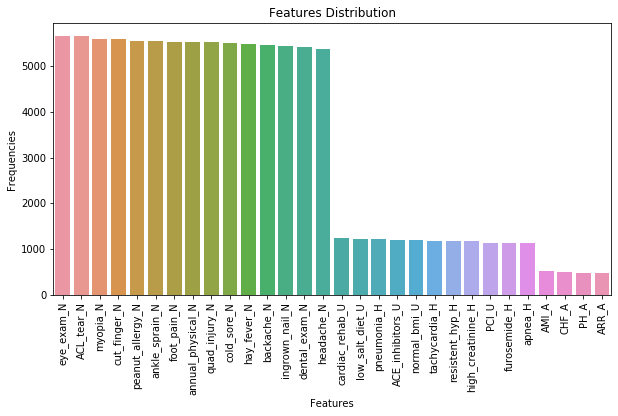

In [169]:
freqs = dict(sorted(freqs.items(), key=lambda item: item[1], reverse=True))

# Plot the feature importances
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x=list(range(len(list(freqs.keys())))),
    y=list(freqs.values()),
    orient="v",
)
z = ax.set_xticklabels(list(freqs.keys()), rotation=90)
plt.title("Features Distribution")
plt.xlabel("Features")
plt.ylabel("Frequencies")
plt.show()